
Diany Pressato 

Matheus Araujo


Modelagem de tópicos em conjuntos de dados distintos (livros, artigos científicos e notícias) com enfoque no modelo BERTopic e utilizando-se também outras metodologias relativas à clusterização. 

# Códigos Gerais

### Instalação de bibliotecas

In [ ]:
!pip install pandas==1.2.0
!pip install pyLDAvis
!pip install googledrivedownloader
!pip install pyyaml==5.4.1
!pip install nltk
!pip install gensim
!pip install unidecode
!pip install bertopic

!pip install gutenbergpy

  Using cached bertopic-0.9.4-py2.py3-none-any.whl (57 kB)
  Using cached hdbscan-0.8.27.tar.gz (6.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached sentence-transformers-2.1.0.tar.gz (78 kB)
  Using cached plotly-5.4.0-py2.py3-none-any.whl (25.3 MB)
     |████████████████████████████████| 86 kB 2.8 MB/s 
     |████████████████████████████████| 3.4 MB 25.5 MB/s 
     |████████████████████████████████| 3.3 MB 34.9 MB/s 
     |████████████████████████████████| 1.2 MB 38.3 MB/s 
     |████████████████████████████████| 61 kB 553 kB/s 
     |████████████████████████████████| 895 kB 53.5 MB/s 
     |████████████████████████████████| 1.1 MB 55.9 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311977 sha256=b8d0e02e0d8c5fb039d5ee60446fcf0a80d7a2c6878f8def723fef2551bd1dde
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206a

### Importação de bibliotecas

In [ ]:
from enum import Enum
from pathlib import Path
import re
import string
from typing import List
import unidecode

from google_drive_downloader import GoogleDriveDownloader as gdd
from bertopic import BERTopic
import gensim
from gensim.models import ldamodel
import gensim.corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from umap import UMAP
import warnings

from nltk.tokenize import word_tokenize

warnings.filterwarnings("ignore", category=DeprecationWarning)
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [ ]:
class GoogleDriveId(Enum):
    FOLHA_NEWS = "removed_link_for_access"
    ARXIV_PAPERS = "removed_link_for_access"
    GUTENBERG_BOOKS = "removed_link_for_access"

for ids in GoogleDriveId:
    print(f"{ids.name}, value = {ids.value}")

FOLHA_NEWS, value = 1a549u_RE74BbJXIKmr7qlloPJGga_y_X
ARXIV_PAPERS, value = 1lywi8BSyHInJkAK4ByCDuHCtt3rc37k2
GUTENBERG_BOOKS, value = 1_698zpbZUxxKXAbs2PAkQqm3X4XKt4ID


### Funções de pré-processamento de textos e documentos

In [ ]:
""" Funções de pré-processamento dos textos """

def texts_to_sentences(texts: List[str], language: str="english", verbose: bool=False) -> List[str]:
  sentences = []
  sentences_sizes = []
  for text in texts:
    tokenized_sentences = sent_tokenize(text, language=language)
    for sentence in tokenized_sentences:
      sentences.append(unidecode.unidecode(sentence))
      sentences_sizes.append(len(sentence.split()))
  
  if verbose:
    print(f"Number of texts = {len(texts)}\nNumber of sentences = {len(sentences)}")
    max_sentence_size = max(sentences_sizes)
    min_sentence_size = min(sentences_sizes)
    mean_sentence_size = sum(sentences_sizes) / len(sentences_sizes)
    print(f"Max sentence = {max_sentence_size} Min sentence = {min_sentence_size} Mean sentence = {mean_sentence_size}")
  
  return sentences

def remove_stopwords(texts: List[str], language: str="english") -> List[str]:
  stop_words = set(stopwords.words(language))
  texts_without_stopwords = []
  for text in texts:
    new_text = " ".join([word.lower() for word in text.split()])
    new_text = unidecode.unidecode(new_text)
    new_text = " ".join([word for word in new_text.split() if not word.lower() in stop_words])
    texts_without_stopwords.append(new_text)
  return texts_without_stopwords

def remove_nonalphabetic(texts: List[str]) -> List[str]:
  alphabetic_texts = []
  regex = re.compile("[%s]" % re.escape(string.punctuation))
  for text in texts:
    new_text = regex.sub("", text) # Remove pontuação
    new_text = unidecode.unidecode(new_text)
    new_text = " ".join([word for word in new_text.split() if len(word) > 1])
    new_text = " ".join([word for word in new_text.split() if not word.isdigit()])
    alphabetic_texts.append(new_text)
  return alphabetic_texts

def remove_small_sentences(texts: List[str], min_number_of_tokens: int=3) -> List[str]:
  new_texts = []
  for text in texts:
    if len(text.split()) >= min_number_of_tokens:
      new_texts.append(text)
  return new_texts

In [ ]:

# retorna um dicionário com o nome do autor sendo a chave e os Paths dos txt's relativos a esse autor contidos no dataset:
def authors_and_books():

  dataset_folder = Path.cwd().joinpath('books')

  dict_all_books = {}

  for author_folder in dataset_folder.iterdir():

      author_name = str(author_folder)
      author_name = author_name.split("/")
      author_name = str(author_name[-1:])
      author_name = author_name.strip("['")
      author_name = author_name.strip("']")

      author_books = []

      #print("nome: ", author_name, "\n ")

      for book_file in author_folder.iterdir():
          
          author_books.append(book_file)

      dict_all_books[author_name] = author_books

  return dict_all_books


# retorna o caminho correto para um título de um autor passado por parâmetro:
def book_path(dict_all_books, author, title) -> str:

  for filepath in dict_all_books[author]:

    temp_filepath = str(filepath)
    temp_filepath = temp_filepath.split("/")
    nome_livro = temp_filepath[-1]
    nome_livro = nome_livro.replace(".txt", "")

    if nome_livro == title:
      return filepath



def read_file(file) -> List[str]:
    
    text = []
    content = file.read_text(encoding="utf-8")
    text.append(content)   

    return text


# retorna todos os documentos relativos a todas as obras de um autor:
def documents_all_books_per_author(author_name) -> List[str]:
  
  count = 0
  all_books_content = []

  for book_path in dict_all_books[author_name]:
    # file_content é uma lista com a string toda do arquivo lido:
    file_content = read_file(book_path)
    all_books_content.append(file_content[0])

    count += 1

    # os livros do Dostoievski são muito grandes! A BERTopic não suporta tantos documentos gerados.
    if count == 4 and author_name == 'Dostoievski':
      break

  documents = texts_to_sentences(all_books_content, verbose=True)

  return documents


### Classes e funções de modelos

In [ ]:
# Modelos

""" Coherence Score para a BERTopic """
def coherence_score_BERTopic(model, model_topics, texts):
  documents = pd.DataFrame({"Document": texts,
                          "ID": range(len(texts)),
                          "Topic": model_topics})
  documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
  cleaned_texts = model._preprocess_text(documents_per_topic.Document.values)

  # Extract vectorizer and analyzer from BERTopic
  vectorizer = model.vectorizer_model
  analyzer = vectorizer.build_analyzer()

  # Extract features for Topic Coherence evaluation
  words = vectorizer.get_feature_names()
  tokens = [analyzer(doc) for doc in cleaned_texts]
  dictionary = gensim.corpora.Dictionary(tokens)
  corpus = [dictionary.doc2bow(token) for token in tokens]
  topic_words = [[words for words, _ in model.get_topic(topic)] 
                for topic in range(len(set(model_topics))-1)]

  # Evaluate
  bertopic_coherence_model = CoherenceModel(topics=topic_words, texts=tokens, corpus=corpus, dictionary=dictionary, coherence='c_v')
  return bertopic_coherence_model.get_coherence()

"""" Latent Dirichlet Allocation (LDA) """
class LDAModel:
  def __init__(self, texts: List[str], number_of_topics: int=8, max_size: int=None, language="english"):
    texts_without_stopwords = remove_stopwords(texts, language=language)
    clean_texts = remove_nonalphabetic(texts_without_stopwords)
    clean_texts = remove_small_sentences(clean_texts)

    clean_texts = clean_texts if max_size is None or max_size > len(clean_texts) else clean_texts[:max_size]
    self.tokenized_texts = [text.split() for text in clean_texts]
    self.id2word = gensim.corpora.Dictionary(self.tokenized_texts)
    self.corpus = [self.id2word.doc2bow(text) for text in self.tokenized_texts]
    self.model = ldamodel.LdaModel(corpus=self.corpus, id2word=self.id2word, num_topics=number_of_topics)

  def topics(self, number_of_topics: int=8):
    word_dict = {}
    for idx in range(number_of_topics):
        words = self.model.show_topic(idx, topn = 10)
        word_dict[f"Topic # {idx:02d}"] = [idx[0] for idx in words]
    return pd.DataFrame(word_dict).T
  
  def visualization(self):
    return gensimvis.prepare(self.model, self.corpus, self.id2word)
  
  def coherence_score(self):
    coherence_model_lda = CoherenceModel(model=self.model, texts=self.tokenized_texts, dictionary=self.id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

""" Nonnegative Matrix Factorization (NMF) """
class NMFModel:
  def __init__(self, texts: List[str], number_of_topics: int=8, max_size: int=None, language="english"):
    texts = remove_small_sentences(texts)
    texts = texts if max_size is None or max_size > len(texts) else texts[:max_size]
    self.tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=language)
    self.tfidf = self.tfidf_vectorizer.fit_transform(texts)
    self.tfidf_feature_names = self.tfidf_vectorizer.get_feature_names()

    self.model = NMF(n_components=number_of_topics, random_state=1, alpha=.1, l1_ratio=.5, init="nndsvd").fit(self.tfidf)

  def topics(self, number_of_top_words: int=10):
    word_dict = {}
    for idx, topic in enumerate(self.model.components_):
      word_dict[f"Topic # {idx:02d}"] = [self.tfidf_feature_names[feature] 
                                                  for feature in topic.argsort()[:-number_of_top_words - 1:-1]]
    return pd.DataFrame(word_dict).T

  def visualization(self):
    visualization_data = pyLDAvis.sklearn.prepare(self.model, self.tfidf, self.tfidf_vectorizer)
    pyLDAvis.display(visualization_data)

  def coherence_score(self):
    raise NotImplementedError("A biblioteca Scikit-Learn não implementa essa métrica\n")

### Visualização UMAP

In [ ]:
""" Visualização UMAP dos embeddings da BERT """
def plot_umap_embeddings(model, topics, texts: List[str], figtitle: str, top_n_topics: int=10):
  all_topics_size = len(model.get_topics())
  embeddings = model._extract_embeddings(texts, method="document")
  umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
  df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
  df["topic"] = topics

  # Plot parameters
  fontsize = 9

  # Slice data
  to_plot = df.copy()
  to_plot[df.topic >= all_topics_size] = -1
  outliers = to_plot.loc[to_plot.topic == -1]
  non_outliers = to_plot.loc[to_plot.topic != -1]

  # Visualize topics
  cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                          '#03A9F4', # Blue
                                          '#4CAF50', # Green
                                          '#80CBC4', # FFEB3B
                                          '#673AB7', # Purple
                                          '#795548', # Brown
                                          '#E91E63', # Pink
                                          '#212121', # Black
                                          '#00BCD4', # Light Blue
                                          '#CDDC39', # Yellow/Red
                                          '#AED581', # Light Green
                                          '#FFE082', # Light Orange
                                          '#BCAAA4', # Light Brown
                                          '#B39DDB', # Light Purple
                                          '#F48FB1', # Light Pink
                                          ])

  # Visualize outliers + inliers
  fig, ax = plt.subplots(figsize=(12, 12))
  scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
  scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)

  # Add topic names to clusters
  centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
  for idx, row in enumerate(centroids.iterrows()):
      if idx > top_n_topics:
        break
      topic = int(row[1].topic)
      text = f"{topic}: " + "_".join([x[0] for x in model.get_topic(topic)[:3]])
      ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')

  ax.text(0.99, 0.01, f"BERTopic - {all_topics_size} tópicos - Os {top_n_topics} melhores tópicos estão rotulados", transform=ax.transAxes, horizontalalignment="right", color="black")
  plt.xticks([], [])
  plt.yticks([], [])

  fig = plt.figure()
  fig.savefig(f"{figtitle}.png", dpi=fig.dpi)
  plt.show()

# Dataset de notícias Folha de São Paulo

Foi utilizado um dataset de notícias da Folha de São Paulo, sendo disponibilizado no site [Kaggle](https://www.kaggle.com/marlesson/news-of-the-site-folhauol). Este foi o único dataset que o grupo não codificou funções para fazer a coleta de dados. Este dataset é o mais processado daqueles que foram utilizados neste trabalho (porém, salienta-se que os outros dois datasets que o grupo coletou possuem uma quantidade muito maior de pré-processamento). Ainda assim, é necessário fazer alguns processamentos textuais neste dataset, como remoção de *stopwords*, remoção de pontuação, remoção de acentuação. Para os modelos NMF e LDA, em alguns casos também foi necessário realizar um processamento de sentenças, pois sentenças com menos do que três *tokens* geravam erros. 

In [ ]:
# Baixar dataset
gdd.download_file_from_google_drive(file_id=GoogleDriveId.FOLHA_NEWS.value, dest_path='/content/folha_news.zip', unzip=True)

Unzipping...Done.


In [ ]:
articles_filename = "articles.csv"
articles_dataframe = pd.read_csv(articles_filename).dropna()
articles_text_body = list(articles_dataframe["text"])

In [ ]:
sentence_tokenized_articles = texts_to_sentences(articles_text_body, language="portuguese", verbose=True)

Number of texts = 29611
Number of sentences = 744552
Max sentence = 788 Min sentence = 1 Mean sentence = 17.944953475378483


## BERTopic

Nesta seção, é feita uma comparação entre os resultados obtidos ao variar o parâmetro *min_topic_size* do modelo BERTopic. Este parâmetro controla o tamanho mínimo de um tópico. Ao aumentar seu valor (que é 10, por padrão), espera-se que o modelo gere um número menor de tópicos, mas estes sejam mais densos.

### Tamanho Mínimo do Tópico = 10 (padrão)

In [ ]:
news_topic_model = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", calculate_probabilities=True, language="portuguese", verbose=True)
topics_10, probabilities = news_topic_model.fit_transform(sentence_tokenized_articles[:10000])

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2021-12-13 23:35:57,132 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-12-13 23:36:47,418 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 23:36:57,594 - BERTopic - Clustered UMAP embeddings with HDBSCAN


A tabela abaixo mostra os principais tópicos. Os tópicos, em geral, parecem coerentes com assuntos de notícias, tratando de assuntos como política (tópico 3 - senado_congresso_parlamentar_parlamentares), eventos (tópico 9 - catalunha_independencia_catalaes_catalao) e pessoas famosas (tópico 6 - alexandre_atores_camargo_atriz). Dado que a BERTopic gera tópicos sematicamente coerentes, os resultados coerentes eram esperados.

In [ ]:
news_topic_model.get_topic_info().head(50)

Topic  Count                                               Name
0      -1   5146                              -1_anos_ele_pais_isso
1       0    324                          0_certo_parece_bom_duvido
2       1    302                 1_bola_futebol_jogadores_argentina
3       2    244                  2_milhoes_mil_metros_apartamentos
4       3    129       3_senado_congresso_parlamentar_parlamentares
5       4     76                     4_cozinha_prato_cafe_sobremesa
6       5     75                            5_cala_questiona_ufa_ah
7       6     75                   6_alexandre_atores_camargo_atriz
8       7     75                       7_paulo_zona_oeste_municipal
9       8     74                8_direita_esquerda_liberal_fascista
10      9     73         9_catalunha_independencia_catalaes_catalao
11     10     68                              10_minha_me_nunca_meu
12     11     65                   11_caiu_queda_trimestre_inflacao
13     12     65                  12_russia_russa_russo_bolchevique
14     13     60                    13_rio_rocinha_violencia_favela
15     14     59    14_cerebro_neuromarketing_neurociencia_cerebros
16     15     57                          15_salvem_pan_piadas_deus
17     16     56              16_impostos_fiscais_fiscal_tributario
20     17     55                             17_rarara_rato_neve_ri
19     18     55  18_democracia_democratico_democraticas_autorit...
18     19     55               19_pobres_desigualdade_ricos_pobreza
21     20     54                   20_minha_concorrencia_gritam_meu
22     21     52            21_mulheres_conselho_conselhos_feminina
23     22     50  22_investimento_investidor_investimentos_inves...
24     23     48                23_livros_livro_editoras_greenblatt
25     24     47             24_transporte_centros_logistica_centro
26     25     46                                 25_19h_20h_18h_21h
27     26     45                          26_hoje_agora_281_concept
28     27     43                       27_museu_museus_arte_artista
29     28     42                   28_ruidos_ruido_acustico_barulho
30     29     40           29_tecnologia_tecnologias_ciencia_futuro
31     30     40           30_politica_politicos_politico_politicas
32     31     38           31_prefeito_goldman_governador_candidato
33     32     38                    32_religioso_igreja_aborto_voto
34     33     36                  33_primeiro_primeira_sinal_apenas
37     35     35                  35_falar_gregos_twitter_linguagem
35     36     35             36_numeros_primo_matematica_matematico
36     34     35                    34_negros_buracos_galaxia_negro
38     37     33                37_armas_desarmamento_arma_atirador
39     38     33                   38_vinhos_vinho_alcoolico_melhor
40     39     33                     39_outubro_novembro_2016_black
41     40     33          40_michel_presidente_brasilia_michelzinho
42     41     32           41_crescimento_desemprego_2009_trimestre
43     42     32                 42_jardins_vegetacao_verdes_parede
44     43     31             43_bancos_financiamento_seguro_poderia
45     44     30                   44_serie_theory_humoristas_jimmy
46     45     30                          45_telefone_11_jardim_rua
47     46     29                           46_arte_art_lixo_artista
48     47     29                   47_quatro_tailandia_dicas_semana
49     48     29                   48_42_cadaver_chiclete_crucifixo

O gráfico abaixo mostra os 8 principais tópicos. Para cada tópico, ele apresenta a palavra mais importante que descreve o tópico. Por exemplo, para o tópico 3, a palavra *senado* é a mais relevante para sua descrição. Note também que neste mesmo tópico 3 ocorrem palavras semanticamente relacionadas à palavra *senado*, como por exemplo a palavra *congresso*.

In [ ]:
news_topic_model.visualize_barchart(top_n_topics=8)

O gráfico abaixo ilustra a distância entre os tópicos. A área do círculo indica a quantidade de documentos que pertencem à um determinado; ou seja, círculos grandes representam que muitos documentos foram agrupados neste tópico.

In [ ]:
news_topic_model.visualize_topics()

O gráfico abaixo mostra a representação UMAP dos embeddings da BERT. Este gráfico permite notar visualmente outliers e perceber padrões de clusterização.

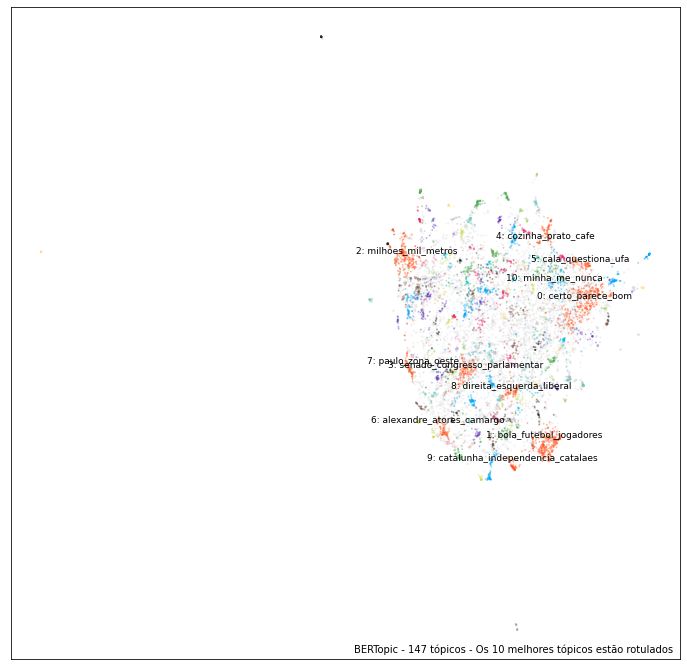

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_umap_embeddings(news_topic_model, topics_10, sentence_tokenized_articles[:10000], figtitle="news_topicsize10")

### Tamanho Mínimo do Tópico = 20

Neste teste, aumentou-se o tamanho mínimo dos tópicos. Isso gera um número menor de clusters, pois cada tópico possuirá um número maior de documentos. Aumentar este valor também tende a gerar mais outliers.

In [ ]:
news_topic_model_20 = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", calculate_probabilities=True, language="portuguese", min_topic_size=20, verbose=True)
topics_20, probabilities = news_topic_model_20.fit_transform(sentence_tokenized_articles[:10000])

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2021-12-14 02:11:54,698 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-12-14 02:12:44,932 - BERTopic - Reduced dimensionality with UMAP
2021-12-14 02:12:48,240 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
news_topic_model_20.get_topic_info().head(50)

Topic  Count                                               Name
0      -1   6018                                -1_dos_mas_anos_diz
1       0    358                         0_copa_brasil_bola_futebol
2       1    188                1_agosto_crescimento_trimestre_2016
3       2    172                             2_certo_sim_duvido_bom
4       3    154                  3_milhoes_metros_mil_apartamentos
5       4    145                     4_revolucao_russia_russa_russo
6       5    134          5_senado_tribunal_congresso_parlamentares
7       6    123           6_cerebro_celulas_animais_neuromarketing
8       7    104             7_logistica_ecologia_naturais_ambiente
9       8    101           8_direita_esquerda_esquerdistas_fascista
10      9     98                 9_livros_livro_editoras_humoristas
11     10     82                                 10_eu_sou_cala_ufa
12     11     74                     11_sera_pais_faculdade_quantas
13     12     71              12_novo_plano_arqueologos_encontraram
14     13     67                       13_falar_fala_objetos_ideias
15     14     66                          14_arte_nudez_artista_art
17     15     64        15_governador_prefeito_candidato_presidente
16     16     64        16_catalunha_independencia_catalaes_catalao
18     17     61     17_compareceram_alexandre_atores_apresentadora
19     18     61                             18_sexta_28_26_cantora
20     19     58                                 19_me_eu_minha_mim
21     20     58               20_exportacoes_milho_setembro_bovina
22     21     55                             21_rarara_rato_neve_ri
23     22     54                      22_rio_porto_violencia_guerra
24     23     54               23_paulo_municipal_oeste_paulistanos
25     24     52                        24_salvem_piadas_deus_salve
26     25     52                  25_resposta_cliente_vivo_internet
27     26     52  26_democracia_democratico_democraticas_democra...
28     27     51                27_cozinha_prato_restaurante_comida
29     28     50               28_pobres_desigualdade_ricos_pobreza
30     29     48            29_mulheres_conselho_conselhos_feminina
31     30     47             30_hoje_assalto_agora_classificariamos
33     31     46                                 31_19h_20h_18h_21h
32     32     46                 32_cena_vaticano_vaidoso_perfeicao
34     33     45       33_tecnologia_tecnologias_futuro_tecnologica
35     34     44                        34_museu_museus_arte_musica
36     35     44           35_petrobras_aluguel_familia_apartamento
37     36     42     36_presidente_candidato_washington_impeachment
38     37     42                   37_ruidos_ruido_acustico_barulho
39     38     41                   38_vinhos_vinho_melhor_alcoolico
40     39     40              39_impostos_fiscais_tributario_fiscal
41     40     40                     40_atencao_angela_pezao_donuts
42     41     39                     41_primeiro_primeira_sinal_foi
43     42     38                    42_negros_buracos_negro_galaxia
44     43     38                43_armas_desarmamento_arma_massacre
45     44     37                     44_loucura_falha_obvio_trivial
46     45     36             45_primo_matematica_matematico_teorema
47     46     34                 46_michel_temer_presidente_governo
48     47     33                 47_religioso_aborto_igreja_escolas
49     48     32                    48_jovens_ensino_educacao_jovem

In [ ]:
news_topic_model_20.visualize_barchart(top_n_topics=8)

Do gráfico abaixo, nota-se que, em relação ao teste com *min_topic_size=10* (padrão), houve uma redução considerável o número de clusters/tópicos, e estes encontram-se mais afastados entre si.

In [ ]:
news_topic_model_20.visualize_topics()

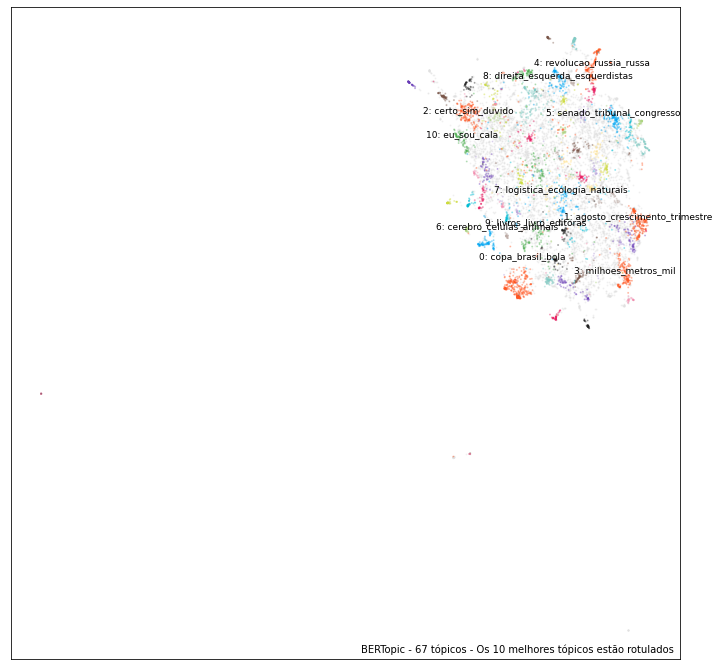

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_umap_embeddings(news_topic_model_20, topics_20, sentence_tokenized_articles[:10000], figtitle="news_topicsize20")

### Análises

Analisando qualitativamente, a qualidade geral dos tópicos não caiu drasticamente. No entanto, nota-se que a versão utilizando tópicos maiores (*min_topic_size = 20*) gerou menos clusters: observando tanto o gráfico de distância entre tópicos quanto o UMAP dos embeddings, nota-se que houve menos clusters (embora sejam maiores) e estes encontram-se mais dispersos no gráfico. 

## NMF

Testou-se também o resultado do modelo NMF. Isto foi feito para comparar o resultado com a BERTopic. Este método não captura a semântica textual, pois é baseado em *bag of words*.

### Partição por artigo

Neste teste, cada artigo de notícia é um documento para o modelo.

In [ ]:
article_NMF_model = NMFModel(articles_text_body, max_size=1000, language=stopwords.words("portuguese"))

In [ ]:
article_NMF_model.topics()

0          1  ...        8            9
Topic # 00               ser       anos  ...     pode          ter
Topic # 01              lula    palocci  ...       pt   presidente
Topic # 02           milhões  toneladas  ...    milho       vendas
Topic # 03  excepcionalmente  publicada  ...     hoje       sábado
Topic # 04         quadrados     metros  ...   centro  apartamento
Topic # 05            rarará       nóis  ...   fufuca      colírio
Topic # 06       corinthians       copa  ...  futebol    jogadores
Topic # 07             janot      temer  ...     jato      batista

[8 rows x 10 columns]

### Partição por sentença

Neste teste, cada sentença de um artigo de notícia é um documento para o modelo, ou seja, um artigo é composto por vários documentos que são passados para o modelo.

In [ ]:
sentence_NMF_model = NMFModel(sentence_tokenized_articles, max_size=1000, language=stopwords.words("portuguese"))

In [ ]:
sentence_NMF_model.topics()

0       1        2  ...              7       8           9
Topic # 00     nao      so    ainda  ...          sobre  nenhum       lugar
Topic # 01    anos    dois       ha  ...     investidor   praca        tres
Topic # 02     ser    deve    podem  ...             40      ja       sobre
Topic # 03     sao   paulo   alguns  ...        selecao  cidade      centro
Topic # 04  brasil  melhor    chile  ...  eliminatorias  perdeu      perder
Topic # 05  tambem  muitos  sucesso  ...      acontecer   norte     artista
Topic # 06    zona     sul    vince  ...          lazer  melhor  industrial
Topic # 07  parece    2018    antes  ...       crivella     fim     bilhoes

[8 rows x 10 columns]

### Análises

Qualitativamente, nota-se que os resultados não são tão bons quanto os da BERTopic. Enquanto o tópico 1 da BERTopic foi "1_bola_futebol_jogadores_argentina", o tópico 1 do NMF contém palavras muito menos descritivas (como "dois", "ha", atras", "tres") e são menos explícitos em seu significado para um leitor. Isso era esperado pois, como comentado, a BERTopic utiliza informações semânticas para a modelagem dos tópicos.

Apesar dos testes entre partição por artigo e partição por sentença, qualitativamente, não notou-se uma diferença muito significante em relação ao resultado obtido.

## LDA

Testou-se também o resultado do modelo LDA. Isto foi feito para comparar o resultado com a BERTopic. Ao contrário da BERTopic, este método não captura a semântica textual, pois é baseado em *bag of words*.

### Partição por artigo

Cada artigo é um documento para o modelo.

In [ ]:
article_LDA_model = LDAModel(articles_text_body, max_size=1000, language="portuguese")

In [ ]:
article_LDA_model.topics()

0    1       2       3  ...       6        7       8       9
Topic # 00  nao  sao      ja  tambem  ...     ser     anos   ainda   sobre
Topic # 01  nao  ser  brasil     sao  ...      ha     pais  tambem   sobre
Topic # 02  nao  sao     ser     diz  ...  tambem  segundo      ha     ate
Topic # 03  nao  sao     ser    anos  ...  brasil      ano      ha      ja
Topic # 04  nao  sao      ha     ser  ...   ainda       ja     diz  tambem
Topic # 05  nao  sao      ja    anos  ...   ainda   tambem     diz   sobre
Topic # 06  nao  sao  tambem     ser  ...    anos      que     ate      ja
Topic # 07  nao  sao      ja     ser  ...  brasil   tambem   ainda     diz

[8 rows x 10 columns]

In [ ]:
article_LDA_model.visualization()

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.003543  0.001162       1        1  31.497879
2     -0.011696  0.003862       2        1  14.365681
1      0.008427  0.008207       3        1  14.295910
7      0.002915  0.001767       4        1  10.592503
4      0.000924  0.005083       5        1  10.102876
6      0.008373 -0.011518       6        1   9.621308
0      0.002774 -0.000300       7        1   5.926124
5     -0.008174 -0.008264       8        1   3.597718, topic_info=            Term         Freq        Total Category  logprob  loglift
429          nao  4069.000000  4069.000000  Default  30.0000  30.0000
596          sao  1348.000000  1348.000000  Default  29.0000  29.0000
360           ja   858.000000   858.000000  Default  28.0000  28.0000
28          anos   847.000000   847.000000  Default  27.0000  27.0000
629       tambem   777.000000   777.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1475  presidente    14.470235   417.698728   Topic8  -6.5434  -0.0378
473        paulo    15.170517   490.237506   Topic8  -6.4961  -0.1507
27           ano    16.639710   678.149335   Topic8  -6.4037  -0.3827
747         dois    14.514018   426.539521   Topic8  -6.5404  -0.0557
452         pais    15.056757   588.543913   Topic8  -6.5037  -0.3410

[702 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
17108      1  0.349911        30h
17108      2  0.349911        30h
18255      1  0.886029   342agora
20307      1  0.132547       360o
20307      2  0.132547       360o
...      ...       ...        ...
37609      2  0.181792  zucolotto
37609      3  0.181792  zucolotto
37609      4  0.181792  zucolotto
37609      7  0.181792  zucolotto
37609      8  0.181792  zucolotto

[1831 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 8, 5, 7, 1, 6])

### Partição por sentença

Cada sentença do artigo é um documento para o modelo, ou seja, um artigo é composto por vários documentos que são passados para o modelo.

In [ ]:
sentence_LDA_model = LDAModel(sentence_tokenized_articles, max_size=1000, language="portuguese")

In [ ]:
sentence_LDA_model.topics()

0       1        2       3  ...       6         7        8         9
Topic # 00   nao     sao  governo  tambem  ...    zona     paulo     hora        ja
Topic # 01   nao  tambem      sao     che  ...    hoje     renda       ja  primeiro
Topic # 02   nao    anos      sao  brasil  ...   custo    regiao     tres  empresas
Topic # 03   ser     nao    sobre    anos  ...   ainda    brasil       ja     maior
Topic # 04   nao     sao      ser   sobre  ...    alem     lugar     copa   projeto
Topic # 05  anos     ano      diz    pode  ...     nao     menos   brasil       ser
Topic # 06   nao     sao   tambem     ser  ...  grande  empresas  ciencia    centro
Topic # 07   nao    pode      ser    deve  ...      la       ate      sao      pais

[8 rows x 10 columns]

In [ ]:
sentence_LDA_model.visualization()

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.058998 -0.015073       1        1  14.577137
0     -0.008738  0.074340       2        1  14.277186
2      0.020990 -0.077922       3        1  13.467969
1     -0.093763  0.049366       4        1  13.126558
4      0.028752 -0.073197       5        1  12.039918
7      0.082425  0.053686       6        1  11.438402
3     -0.036175 -0.043643       7        1  11.258123
5      0.065506  0.032444       8        1   9.814708, topic_info=        Term       Freq       Total Category  logprob  loglift
31      anos  42.000000   42.000000  Default  30.0000  30.0000
25      pode  23.000000   23.000000  Default  29.0000  29.0000
696      che  10.000000   10.000000  Default  28.0000  28.0000
0        ano  19.000000   19.000000  Default  27.0000  27.0000
86       ate  22.000000   22.000000  Default  26.0000  26.0000
..       ...        ...         ...      ...      ...      ...
138      nao   3.968918  110.601523   Topic8  -5.6892  -1.0062
409       ha   2.426677   23.602090   Topic8  -6.1812   0.0465
297    areas   2.160438   13.896051   Topic8  -6.2974   0.4600
70   mercado   2.138707   15.116393   Topic8  -6.3075   0.3657
290    estao   2.006644   11.057249   Topic8  -6.3712   0.6147

[586 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4493      7  0.727604  aceitacao
1953      7  0.481180   acredita
1298      1  0.203509     afirma
1298      2  0.203509     afirma
1298      3  0.135673     afirma
...     ...       ...        ...
392       4  0.118938       zona
392       5  0.178407       zona
392       6  0.059469       zona
392       7  0.059469       zona
392       8  0.059469       zona

[1297 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 3, 2, 5, 8, 4, 6])

### Análises

Qualitativamente, nota-se que os resultados não são tão bons quanto os da BERTopic. Enquanto o tópico 1 da BERTopic foi "1_bola_futebol_jogadores_argentina", o tópico 1 do LDA ("nao	tambem	sao	che	ainda	outro	hoje	renda	ja	primeiro") contém palavras muito menos descritivas (como "che", "sao", "ainda", "ja") e os tópicos encontrados são menos explícitos em seu significado para um leitor. Ao contrário da BERTopic, também nota-se uma grande repetição de algumas palavras entre vários tópicos, como as palavras "nao", "sao" e "sobre". Isso era esperado pois, como comentado, a BERTopic utiliza informações semânticas para a modelagem dos tópicos.

Apesar dos testes entre partição por artigo e partição por sentença, qualitativamente, não notou-se uma diferença muito significante em relação ao resultado obtido.

# Dataset de *Abstracts* de artigos científicos do site ArXiv

Neste trabalho, codificaram-se funções para baixar e processar diversos artigos científicos (*papers*) do site ArXiv. Isso foi feito através de uma biblioteca em Python que se comunica com a API pública do site. 

Foram feitas diversas requisições de diversas categorias de artigos científicos (como inteligência artificial, aprendizado de máquina, robótica, genômica, dentre outros). Para cada categoria, foram coletadas as seções *abstract*  de 3000 artigos científicos em dez categorias diferentes, totalizando um conjunto de dados de 30000 artigos científicos coletados. Embora a implementação realizada tenha baixado apenas o *abstract* de cada artigo, em trabalhos futuros seria simples implementar uma funcionalidade para baixar várias outras informações, como referências ou o corpo inteiro do artigo, bastando alterar a requisição feita à API.

Os arquivos foram baixados por ordem de publicação no site do ArXiv; isto é, para cada categoria, foram baixados os 3000 artigos mais recentemente publicados. Isso permite fazer uma análise qualitativa dos principais tópicos mais recentemente pesquisados em diversas áreas do conhecimento, como será discutido a partir dos resultados.

O conteúdo do *abstract* dos artigos científicos baixados, no entanto, é texto em formato LaTeX. Por isso, foi necessário implementar uma etapa extensa de pré-processamento de textos para remover caracteres e comandos especiais do LaTeX (como \matbhf, \href e $$), expressões e símbolos matemáticos (como letras gregas utilizadas como símbolos em fórmulas), caracteres que não podem ser imprimidos, dentre outros. Além disso, assim como no dataset de notícias, foi necessário processar e remover pontuações, acentuações e outros símbolos dos textos.


Assim, este dataset representou para o grupo um grande desafio para coleta e pré-processamento, mas também foi uma grande oportunidade para aprender e se aprofundar mais nessa etapa tão importante que é a mineração de dados.


In [ ]:
# Baixar dataset, que foi coletado e processado pelo grupo.
gdd.download_file_from_google_drive(file_id=GoogleDriveId.ARXIV_PAPERS.value, dest_path='/content/arxiv-papers.zip', unzip=True)

Unzipping...Done.


In [ ]:
def retrieve_files_from_directory(path: Path, file_suffix: str) -> List[Path]:
  glob_pattern = "**/*" + file_suffix
  return [path for path in path.glob(glob_pattern) if path.is_file()]

def retrieve_abstract_texts(path: Path) -> List[str]:
  filepaths = retrieve_files_from_directory(path, ".txt")
  return [current_file.read_text() for current_file in filepaths]

def retrieve_most_recent_abstract(path: Path, count: int) -> List[str]:
  abstract_filepaths = retrieve_files_from_directory(path, ".txt")
  recent_abstract_paths = []
  for filepath in abstract_filepaths:
    index = int(filepath.name.split(".")[0])
    if index <= count:
      recent_abstract_paths.append(filepath.read_text())
  return recent_abstract_paths

Abaixo, seguem-se todas as categorias que foram baixadas e processadas do site do ArXiv. Para cada categoria, foram processados aproximadamente 3000 arquivos, sendo selecionados por data de submissão (isto é, selecionando os mais recentes primeiro.

In [ ]:
papers_categories = [
        "graphics",
        "vision",
        "robotics",
        "artificial-intelligence",
        "machine-learning",
        "differential-geometry",
        "numerical-analysis",
        "quantum-physics",
        "medical-physics",
        "genomics"
]

## Resultados de *topic modelling* por categoria de artigo científico

Dentre todas as categorias, são apresentados os resultados gerais dos tópicos encontrados pela BERTopic em um subconjunto das categorias. Na seção seguinte, os resultados de uma das categorias será explicado em mais detalhes e serão comparados com outros parâmetros e com outros modelos (NMF e LDA).

In [ ]:
selected_categories = (papers_categories[0], papers_categories[3], papers_categories[-3])
data_by_category = {}
for category in selected_categories:
  data_by_category[category] = retrieve_abstract_texts(Path(category))
  for abstract in data_by_category[category]:
    if len(abstract.split()) > 512:
      print(f"Aviso: Abstract da categoria {category} possui mais de 512 tokens.")

In [ ]:
models_by_category = {}
topics_by_category = {}
for category in selected_categories:
  models_by_category[category] = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", calculate_probabilities=True, verbose=True)
  topics_by_category[category], __ = models_by_category[category].fit_transform(data_by_category[category])

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2021-12-13 23:44:37,435 - BERTopic - Transformed documents to Embeddings
2021-12-13 23:44:57,569 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 23:44:58,211 - BERTopic - Clustered UMAP embeddings with HDBSCAN


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2021-12-13 23:45:35,946 - BERTopic - Transformed documents to Embeddings
2021-12-13 23:45:55,479 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 23:45:56,062 - BERTopic - Clustered UMAP embeddings with HDBSCAN


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2021-12-13 23:46:33,355 - BERTopic - Transformed documents to Embeddings
2021-12-13 23:46:52,934 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 23:46:53,644 - BERTopic - Clustered UMAP embeddings with HDBSCAN


Abaixo, pode-se visualizar o resultados dos principais tópicos da categoria *computação gráfica*, e dentro de cada tópico, os principais termos utilizados. Nota-se que o resultado é bem coerente com o esperado, tratando de assuntos como animação, iluminação, superfícies, modelos tridimensionais, cores etc. Nota-se a presença também de um tópico relativo à redes neurais no contexto de formas tridimensionais.

In [ ]:
models_by_category["graphics"].visualize_barchart(top_n_topics=8)

Abaixo é apresentada a medida Coherence Score para os tópicos relativos à categoria computação gráfica.

In [ ]:
coherence_score_BERTopic(models_by_category["graphics"], topics_by_category["graphics"], data_by_category["graphics"])

0.5341656441455713

Abaixo, pode-se visualizar o resultados dos principais tópicos da categoria *inteligência artificial*, e dentro de cada tópico, os principais termos utilizados. Nota-se que o resultado é bem coerente com o esperado, tratando de assuntos como redes neurais, grafos, robôs, linguagens, áudio e aprendizado de máquina. Um tópico parece se referir predominantemente à assuntos relativos à tráfego e veículos; hipotetiza-se que artigos científicos relativos à carros autonônomos tenham gerado esse tipo de tópico.

In [ ]:
models_by_category["artificial-intelligence"].visualize_barchart(top_n_topics=8)

Abaixo é apresentada a medida Coherence Score para os tópicos relativos à categoria inteligência artificial.

In [ ]:
coherence_score_BERTopic(models_by_category["artificial-intelligence"], topics_by_category["artificial-intelligence"], data_by_category["artificial-intelligence"])

0.5197044674762159

Abaixo, pode-se visualizar o resultados dos principais tópicos da categoria *física quântica*, e dentro de cada tópico, os principais termos utilizados. Nota-se que o resultado é bem coerente com o esperado, tratando de temas como fótons, spins, orbitais, *qubits* (computação quântica) e simulações.

In [ ]:
models_by_category["quantum-physics"].visualize_barchart(top_n_topics=8)

Abaixo é apresentada a medida Coherence Score para os tópicos relativos à categoria de física quântica.

In [ ]:
coherence_score_BERTopic(models_by_category["quantum-physics"], topics_by_category["quantum-physics"], data_by_category["quantum-physics"])

0.5238112566953077

## Influência do período de submissão

A seguir, é feita uma análise da influência que o período de submissão pode ter sobre os tópicos encontrados pelo modelo BERTopic. O objetivo desse teste é verificar como os tópicos mais presentes em publicações científicas variam ao considerar intervalos de tempo maiores.

No teste, comparou-se o resultado anterior (utilizando os *abstracts* de 3000 artigos científicos da categoria computação gráfica) com o resultado de utilizar apenas os 1000 artigos científicos mais recentes desta mesma categoria.

In [ ]:
recent_graphics_files = retrieve_most_recent_abstract(Path("graphics"), count=1000)

In [ ]:
recent_graphics_papers_model = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", calculate_probabilities=True, verbose=True)
recent_graphics_topics, __ = recent_graphics_papers_model.fit_transform(recent_graphics_files)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2021-12-13 23:48:16,497 - BERTopic - Transformed documents to Embeddings
2021-12-13 23:48:23,582 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 23:48:23,692 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
models_by_category["graphics"].visualize_barchart(top_n_topics=8)

In [ ]:
recent_graphics_papers_model.visualize_barchart(top_n_topics=8)

Nas duas células acimas, são apresentados os resultados da modelagem de tópicos utilizando os 3000 artigos científicos e 1000 artigos científicos mais recentes da categoria de computação gráfica, respectivamente. 

Em geral, os tópicos são semelhantes, como esperado, ainda envolvendo animação, superfícies tridimensionais e iluminação. No entanto, destaca-se que no resultado utilizando apenas os 1000 artigos científicos mais recentes, o tópico sobre redes neurais (que era mais genérico) foi substituído por tópicos que envolvem redes neurais mas são mais específicos, como StyleGANs e Neural Radiance Fields, que são redes neurais que podem ser utilizadas para síntese de imagens em aplicações gráficas.

As duas células abaixo analisam a métrica Coherence Score. Nota-se que o valor obtido é melhor ao considerar um intervalo de tempo maior, isto é, obteve-se um resultado melhor ao considerar os 3000 artigos mais recentes ao invés de apenas os 1000 artigos mais recentes.

In [ ]:
coherence_score_BERTopic(models_by_category["graphics"], topics_by_category["graphics"], data_by_category["graphics"])

0.5341656441455713

In [ ]:
coherence_score_BERTopic(recent_graphics_papers_model, recent_graphics_topics, recent_graphics_files)

0.4982561752038808

## *Topic modelling* considerando todas as categorias

Neste teste, vários artigos de categorias diferentes foram unidas para verificar se o modelo BERTopic ainda seria capaz de discernir claramente os tópicos referentes à cada área. Assim, pode-se obter quais os tópicos mais recorrentes em artigos científicos num intervalo de tempo considerando diversas áreas do conhecimento.

Nos testes a seguir, utilizaram-se 1000 artigos científicos por categoria, sendo escolhidos os 1000 mais recentes de cada categoria.

In [ ]:
all_abstracts = []
for category in papers_categories:
  current_data = retrieve_most_recent_abstract(Path(category), count=1000)
  for abstract in current_data:
    if len(abstract.split()) > 512:
      print(f"Aviso: Abstract da categoria {category} possui mais de 512 tokens.")
    all_abstracts.append(abstract)

In [ ]:
all_papers_model = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", calculate_probabilities=True, verbose=True)
all_papers_topics, __ = all_papers_model.fit_transform(all_abstracts)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2021-12-13 23:50:38,101 - BERTopic - Transformed documents to Embeddings
2021-12-13 23:51:05,604 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 23:51:14,069 - BERTopic - Clustered UMAP embeddings with HDBSCAN


Como pode-se notar pelos dois gráficos abaixo, o modelo foi capaz de gerar tópicos de forma satisfatória e coerente. Pode-se notar tópicos referentes à matemática, física médica e robótica. Destaca-se que alguns tópicos são recorrentes entre diversas categorias: por exemplo, robótica é uma categoria própria, porém também é relacionada à inteligência artificial e aprendizado de máquina. Outro exemplo é o tópico que contém palavras como *equações* e *convergência*. Como a maioria das categorias testadas possuem componentes matemáticos fortes em suas áreas e descrições, esse tópico deve ter sido considerado recorrente no conjunto testado. Assim, hipotetiza-se que o fato de alguns tópicos aparecerem em diferentes categorias simultaneamente aumenta a probabilidade de aparecerem entre os tópicos selecionados.

In [ ]:
all_papers_model.visualize_barchart(top_n_topics=8)

No gráfico abaixo, pode-se notar que os tópicos semelhantes ficam espacialmente muito próximos. Ao considerar diferentes categorias de artigos científicos, o afastamento dos tópicos tornou-se mais acentuado.

In [ ]:
all_papers_model.visualize_topics()

## Inserção de ruído para análise de *outliers*

Nesta seção, foi testado a inserção de outliers no conjunto de dados. Para isso, dado o conjunto de artigos científicos da categoria de inteligência artificial, foram inseridos algumas sentenças (10% do tamanho total do conjunto de dados) do dataset de notícias da Folha de São Paulo. Isto foi feito para observar o efeito que outiliers tem sobre o modelo.

In [ ]:
total_size = len(data_by_category["artificial-intelligence"])
outliers_size = int(0.1 * total_size)
data_with_outliers = data_by_category["artificial-intelligence"][:total_size-outliers_size] + sentence_tokenized_articles[:outliers_size]
#print(len(data_with_outliers))
#print(data_with_outliers[0])
#print(data_with_outliers[-1])

In [ ]:
outliers_model = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", calculate_probabilities=True, verbose=True)
outliers_topics, __ = outliers_model.fit_transform(data_with_outliers)

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2021-12-13 23:52:02,442 - BERTopic - Transformed documents to Embeddings
2021-12-13 23:52:21,754 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 23:52:22,445 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
models_by_category["artificial-intelligence"].visualize_barchart(top_n_topics=8)

In [ ]:
outliers_model.visualize_barchart(top_n_topics=8)

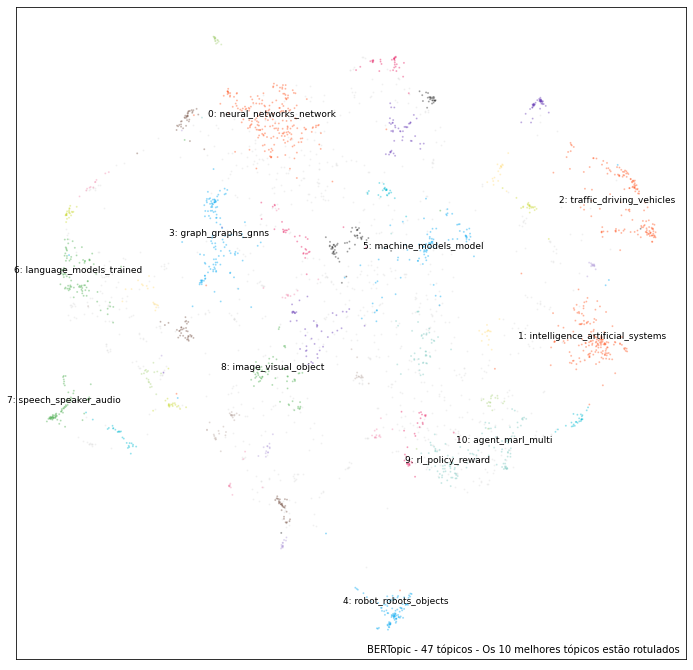

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_umap_embeddings(models_by_category["artificial-intelligence"], topics_by_category["artificial-intelligence"], data_by_category["artificial-intelligence"], figtitle="AI_no_outliers")

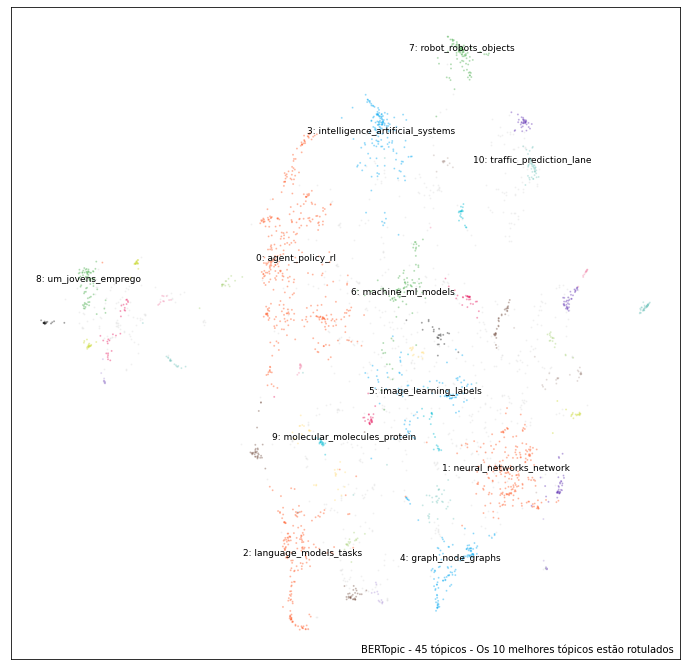

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_umap_embeddings(outliers_model, outliers_topics, data_with_outliers, figtitle="AI_with_outliers")

Nas duas figuras acima, fica evidente a diferença que outliers tem sobre o modelo. Na figura imediatamente acima, há um tópico visivelmente afastado e em língua portuguesa, representando o conjunto de outliers que foi inserido.

## Variações de parâmetros e comparações

Nas subseções a seguir, são feitas análises do impacto do tamanho dos tópicos e comparações entre os resultados dos três diferentes modelos (BERTopic, NMF e LDA).

## BERTopic

Nas duas seções abaixo, verificou-se qual o impacto do tamanho mínimo dos tópicos no resultado obtido para os artigos científicos da categoria de inteligência artificial.

### Tamanho Mínimo do Tópico = 10 (padrão)

In [ ]:
models_by_category["artificial-intelligence"].visualize_barchart(top_n_topics=8)

In [ ]:
models_by_category["artificial-intelligence"].visualize_topics()

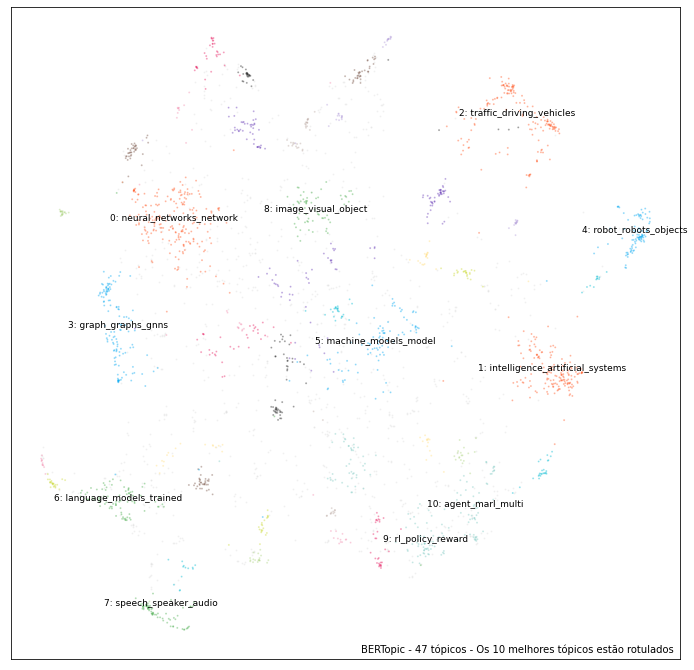

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_umap_embeddings(models_by_category["artificial-intelligence"], topics_by_category["artificial-intelligence"], data_by_category["artificial-intelligence"], figtitle="arxiv_topicsize10")

In [ ]:
coherence_score_BERTopic(models_by_category["artificial-intelligence"], topics_by_category["artificial-intelligence"], data_by_category["artificial-intelligence"])

0.5197044674762159

### Tamanho Mínimo do Tópico = 20

In [ ]:
arxiv_topic_model_20 = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", calculate_probabilities=True, min_topic_size=20, verbose=True)
arxiv_topics_size_20, __ = arxiv_topic_model_20.fit_transform(data_by_category["artificial-intelligence"])

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2021-12-13 23:55:47,608 - BERTopic - Transformed documents to Embeddings
2021-12-13 23:56:06,940 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 23:56:07,276 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
arxiv_topic_model_20.visualize_barchart(top_n_topics=8)

In [ ]:
arxiv_topic_model_20.visualize_topics()

Como esperado, ao utilizar o parâmetro *min_topic_size = 20* no modelo da BERTopic, houve uma redução significativa no número de clusters em relação ao valor padrão (*min_topic_size = 10*)

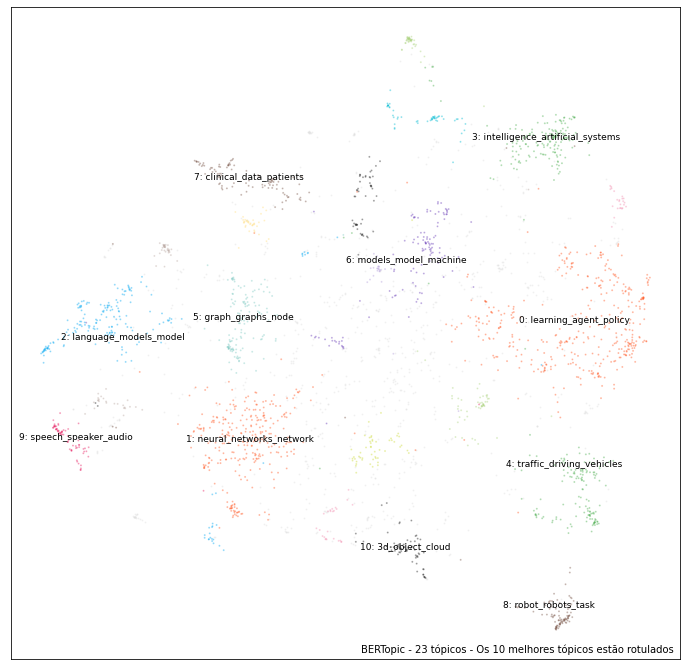

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_umap_embeddings(arxiv_topic_model_20, arxiv_topics_size_20, data_by_category["artificial-intelligence"], figtitle="arxiv_topicsize20")

## Análises

Como esperado, os gráficos *Intertopic Distance Map* indicam que o primeiro resultado (utilizando o valor padrão) gera mais tópicos e tópicos menores, enquanto o segundo gera menos tópicos e tópicos maiores. Ao fazer a visualização dos embeddings da BERT através do UMAP, os dados utilizando *min_topic_size=20* estão mais dispersos e indicam uma maior presença de outliers, como também era esperado.

## NMF

Abaixo, foi verificado o resultado do modelo NMF para os artigos científicos da categoria de inteligência artificial. O valor da métrica Coherence Score não pode ser obtida, pois esta métrica não está implementada na biblioteca Scikit-Learn para este modelo.

In [ ]:
arxiv_NMF_model = NMFModel(data_by_category["artificial-intelligence"])

In [ ]:
arxiv_NMF_model.topics()

0          1  ...              8            9
Topic # 00         data   learning  ...         method  performance
Topic # 01           rl     policy  ...       policies  environment
Topic # 02           ai    systems  ...    explainable  development
Topic # 03        graph       node  ...      structure    embedding
Topic # 04     language     models  ...      knowledge         fine
Topic # 05       object         3d  ...           pose           2d
Topic # 06           fl  federated  ...    distributed        local
Topic # 07  adversarial    attacks  ...  perturbations       models

[8 rows x 10 columns]

### Análises

Em geral, o modelo NMF gera tópicos razoáveis. Nota-se que os tópicos são razoavelmente diferentes daqueles encontrados pela BERTopics. No entanto, em relação ao resultado da BERTopic, nota-se uma presença maior de palavras que não são tão significantes para a semântica do tópico, como *xai* e *pre*, e também de abreviações, como *nlp*, *rl* e *ai*.  Por isso, qualitativamente, o resultado da BERTopic gerou tópicos mais semanticamente correlacionados.

## LDA

Abaixo, foi verificado o resultado do modelo LDA para os artigos científicos da categoria de inteligência artificial. Também foi calculada a métrica Coherence Score para comparação quantitativa com o resultado da BERTopic.

In [ ]:
arxiv_LDA_model = LDAModel(data_by_category["artificial-intelligence"])

In [ ]:
arxiv_LDA_model.topics()

0         1         2  ...          7            8        9
Topic # 00      data     model  learning  ...         3d        using  network
Topic # 01      data  learning     model  ...  algorithm    framework     show
Topic # 02  learning    models      data  ...   training  performance     work
Topic # 03  learning     model     graph  ...     method      network   models
Topic # 04  learning      data  language  ...    propose        graph  methods
Topic # 05  learning     model  proposed  ...     models     approach    paper
Topic # 06     model    models      data  ...   learning    different     show
Topic # 07  learning     model      data  ...      tasks      propose    paper

[8 rows x 10 columns]

In [ ]:
arxiv_LDA_model.coherence_score()

0.2939226484356804

### Análises

Em geral, os tópicos gerados pelo modelo são razoáveis. No entanto, em comparação com a BERTopic, nota-se uma grande repetição de termos em diversos tópicos distintos, como *learning*, *model* (ou *models*) e *methods*. Por isso, qualitativamente, o resultado da BERTopic gerou tópicos mais semanticamente correlacionados.

O resultado do Coherence Score foi pior para o LDA (que foi de aproximadamente 0.29) do que para a BERTopic (que foi de aproximadamente 0.52, como pode ser visto em células acima), o que está coerente com nossa análise qualitativa de que a BERTopic gerou tópicos mais semanticamente relacionados.

Assim, para o caso de *abstract* de artigos científicos, a BERTopics parece ter oferecido melhores resultados tanto qualitativa quanto quantitativamente.



# Dataset de Livros

## O dataset utilizado é referente ao arquivo books.zip, que consiste em arquivos pré processados dos livros extraídos do Projeto Gutenberg. Os livros são todos em inglês. São consideradas como documentos as frases contidas em um texto. Considerar frases como documentos é uma recomendação quando os documentos são extensos, passando da capacidade de 512 tokens por documento relativa à arquitetura da BERTopic.

In [ ]:
gdd.download_file_from_google_drive(file_id=GoogleDriveId.GUTENBERG_BOOKS.value, dest_path='/content/books.zip', unzip=True)

Unzipping...Done.


## Obtendo os tópicos para o livro "Crime and Punishment" de Dostoievski:

In [ ]:
dict_all_books = authors_and_books()

print(dict_all_books.keys())
print(dict_all_books.values())

dict_keys(['Shakespeare', 'Dostoievski', 'Lewis Carrol'])
dict_values([[PosixPath('/content/books/Shakespeare/hamlet.txt'), PosixPath('/content/books/Shakespeare/Othello.txt'), PosixPath('/content/books/Shakespeare/A_Midsummer_Nights_Dream.txt'), PosixPath('/content/books/Shakespeare/Romeo_And_Juliet.txt'), PosixPath('/content/books/Shakespeare/Macbeth.txt')], [PosixPath('/content/books/Dostoievski/the_gambler.txt'), PosixPath('/content/books/Dostoievski/the_idiot.txt'), PosixPath('/content/books/Dostoievski/the_possessed.txt'), PosixPath('/content/books/Dostoievski/white_knights.txt'), PosixPath('/content/books/Dostoievski/short_stories.txt'), PosixPath('/content/books/Dostoievski/brothers_karamazov.txt'), PosixPath('/content/books/Dostoievski/the_grand_inquisitor.txt'), PosixPath('/content/books/Dostoievski/poor_folk.txt'), PosixPath('/content/books/Dostoievski/crime_and_punishment.txt')], [PosixPath('/content/books/Lewis Carrol/Alice_In_Wonderland.txt'), PosixPath('/content/books/Le

In [ ]:
path = book_path(dict_all_books, 'Dostoievski', 'crime_and_punishment')
path

PosixPath('/content/books/Dostoievski/crime_and_punishment.txt')

In [ ]:
file_content = read_file(path)
documents= texts_to_sentences(file_content, verbose=True)

Number of texts = 1
Number of sentences = 11906
Max sentence = 265 Min sentence = 1 Mean sentence = 17.026205274651435


In [ ]:
topic_model = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(documents)


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/373 [00:00<?, ?it/s]

2021-12-16 23:06:13,068 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-12-16 23:07:27,985 - BERTopic - Reduced dimensionality with UMAP
2021-12-16 23:07:49,959 - BERTopic - Clustered UMAP embeddings with HDBSCAN


Seguem os 100 principais tópicos obtidos para o livro Crime e Castigo:

In [ ]:
topic_model.get_topic_info().head(100)

Topic  Count                                     Name
0       -1   5296                         -1_and_the_he_to
1        0    509                        0_he_had_felt_his
2        1    273          1_raskolnikov_answered_said_you
3        2    268          2_petrovitch_pyotr_porfiry_ilya
4        3    250                     3_sonia_her_she_said
..     ...    ...                                      ...
91      94     17                  94_room_small_rooms_six
89      92     17             92_roubles_six_silver_father
100     96     16  96_conversation_subject_spoke_conceited
99      97     16           97_mikolka_cart_shouted_gallop
98      98     16  98_couldn_expose_enterprise_practically

[100 rows x 3 columns]

Note que o tópico -1 representa outliers do modelo. Ou seja, não é considerado um tópico relevante para análises. O atributo "Count" indica quantos documentos foram considerados como outliers para o modelo:

In [ ]:
freq = topic_model.get_topic_info(); freq.head(15)

Topic  Count                                    Name
0      -1   5296                        -1_and_the_he_to
1       0    509                       0_he_had_felt_his
2       1    273         1_raskolnikov_answered_said_you
3       2    268         2_petrovitch_pyotr_porfiry_ilya
4       3    250                    3_sonia_her_she_said
5       4    229          4_ivanovna_katerina_amalia_she
6       5    194              5_tea_drunk_drink_drinking
7       6    175               6_door_stairs_opened_open
8       7    140              7_mother_sister_her_dounia
9       8    131                     8_why_should_are_am
10      9    129              9_shouted_voice_crowd_said
11     10    119  10_alexandrovna_pulcheria_rodya_dounia
12     11    117                11_table_pillow_sofa_sat
13     12    114                       12_ah_ach_bah_hey
14     13    110          13_razumihin_cried_mr_zossimov

In [ ]:
topic_model.get_topic(0)  # Seleciona o tópico mais frequente

[('he', 0.015748070994712735),
 ('had', 0.012652733641046675),
 ('felt', 0.012000724437239367),
 ('his', 0.011895122140117917),
 ('was', 0.011820549477311293),
 ('him', 0.01047973738593441),
 ('not', 0.00902328105663841),
 ('of', 0.00873653069417533),
 ('could', 0.008589294816949361),
 ('that', 0.008512243968571923)]

In [ ]:
topic_model.get_topic(1)  # Seleciona o segundo tópico mais frequente

[('raskolnikov', 0.06004239492850706),
 ('answered', 0.016173212078143824),
 ('said', 0.013640135260751212),
 ('you', 0.011524926336520285),
 ('asked', 0.00965795724557793),
 ('me', 0.009339726823516298),
 ('it', 0.00905754156867868),
 ('thought', 0.007804851016587551),
 ('what', 0.00749296855510624),
 ('is', 0.007186640218901841)]

In [ ]:
topic_model.get_topic(2)  # Seleciona o terceiro tópico mais frequente

[('petrovitch', 0.07321480284330126),
 ('pyotr', 0.05154045397946697),
 ('porfiry', 0.02667476442435195),
 ('ilya', 0.01938600982685618),
 ('petersburg', 0.017721209610304035),
 ('his', 0.008082844249956783),
 ('to', 0.007552414307242928),
 ('though', 0.0072185730008435985),
 ('of', 0.006858449771036001),
 ('with', 0.006574812152743149)]

In [ ]:
topic_model.visualize_barchart(top_n_topics=8)

In [ ]:
coherence_score_BERTopic(topic_model, topics, documents)

0.5430894448776157

Por curiosidade, observamos que uma determinada palavra passada por parâmetro pelo usuário pode ser relacionada com alguns tópicos gerados pelo modelo. Por exemplo, a palavra "death" se correlaciona com as demais com as seguintes probabilidades:

* 'killed': 0.0428578192267743)
* 'old': 0.08938587560146177
* 'microbes': 0.07903835744487044

Note que estas palavras, para a intuição do ser humano, são todas relacionadas à morte!


Notamos também que as palavras representativas de um tópico se referem à personagens: Ptrovich, Pyotr, Ivanovna, SOnia, etc

In [ ]:
similar_topics, similarity = topic_model.find_topics("death", top_n=3); 

print(similar_topics, similarity)

[43, 30, 105] [0.8155944222347972, 0.8078335016086696, 0.8017588881171751]


In [ ]:
for topic in similar_topics:
  print(topic_model.get_topic(topic))

[('killed', 0.0428578192267743), ('sister', 0.02190373129665596), ('murdering', 0.01978903733343999), ('sold', 0.015305945241707431), ('copper', 0.014991904956587232), ('murdered', 0.012382460135860258), ('feet', 0.012031392965498459), ('kill', 0.012031392965498459), ('incidentally', 0.010927524897062686), ('hypothesis', 0.010927524897062686)]
[('old', 0.08938587560146177), ('murder', 0.041118916071595714), ('killed', 0.02750043400384684), ('kill', 0.022057553770080507), ('murdered', 0.018160941532595048), ('older', 0.012110622375302749), ('age', 0.010994063634830636), ('listen', 0.010727626870107027), ('died', 0.00859272529894406), ('murderer', 0.008384397037076682)]
[('microbes', 0.07903835744487044), ('condemned', 0.06595963972263104), ('killed', 0.06419106406510168), ('death', 0.040718407148820426), ('killing', 0.034065067223184295), ('accused', 0.034065067223184295), ('scientific', 0.034065067223184295), ('attacked', 0.034065067223184295), ('attacking', 0.03297981986131552), ('int

### reduzindo o número de tópicos a serem gerados pelo modelo para 50:

In [ ]:
# reduzindo número de tópicos:
topic_model = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", calculate_probabilities=True, verbose=True, nr_topics=50)
topics, probs = topic_model.fit_transform(documents)

Batches:   0%|          | 0/373 [00:00<?, ?it/s]

2021-12-14 00:02:16,280 - BERTopic - Transformed documents to Embeddings
2021-12-14 00:02:33,626 - BERTopic - Reduced dimensionality with UMAP
2021-12-14 00:02:44,966 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-12-14 00:02:56,347 - BERTopic - Reduced number of topics from 134 to 51


In [ ]:
topic_model.get_topic_info().head(50)

Topic  Count                                        Name
0      -1   5340                          -1_all_me_have_for
1       0    317             0_felt_thought_sensation_seemed
2       1    277              1_ivanovna_amalia_lizaveta_her
3       2    267                      2_sonia_no_cried_hands
4       3    265                   3_heart_brother_afraid_my
5       4    264       4_petrovitch_pyotr_porfiry_petersburg
6       5    248                     5_sofa_table_sat_pocket
7       6    246               6_remember_waiting_eyes_stood
8       7    203            7_doctor_stone_article_yesterday
9       8    199           8_raskolnikov_asked_said_answered
10      9    195                9_mikolka_cried_sing_shouted
11     10    183                  10_door_opened_open_stairs
12     11    171                   11_why_should_crying_they
13     12    168              12_window_dreams_windows_dream
14     13    165                 13_shouted_voice_heard_hear
15     14    152                   14_fool_character_she_mad
16     15    151                     15_mother_sister_her_my
17     16    140                16_bridge_market_street_neva
18     17    130          17_smile_laughed_laughing_laughter
19     18    130                         18_father_ah_bah_oh
20     19    129               19_began_breath_started_begun
21     20    127                     20_looked_lips_eyes_see
22     21    121                      21_old_face_young_thin
23     22    116         22_alexandrovna_rodya_cried_timidly
24     23    115               23_lying_evidence_truth_facts
25     24    111             24_money_painter_hands_painters
26     25    108                    25_she_her_daughter_wife
27     26    106                     26_tea_drink_drunk_beer
28     27    106                      27_men_man_right_world
29     28     98                             28_foo_oh_eh_ah
30     29     98       29_svidrigailov_answered_said_laughed
31     30     96              30_thought_think_mind_answered
32     31     93                    31_know_knew_knows_known
33     32     90                  32_right_wrong_crime_think
34     33     89                 33_romanovna_avdotya_her_if
35     34     86      34_nikolay_nikodim_pestryakov_evidence
36     35     84              35_rodion_romanovitch_rodya_ro
38     36     81           36_believe_possible_could_perhaps
37     37     81  37_understand_explain_explained_understood
39     38     74                 38_zametov_zossimov_why_mad
40     39     71                   39_where_here_let_clothes
41     40     70           40_roubles_twenty_funeral_fifteen
42     41     70                         41_yes_no_gogol_not
43     42     65             42_letter_received_sent_morning
44     43     64           43_sofya_semyonovna_mamma_roubles
45     44     62              44_marfa_petrovna_know_country
46     45     59              45_silence_minutes_minute_half
47     46     59              46_couldn_impossible_can_never
48     47     58          47_police_policeman_office_station
49     48     54                   48_what_mean_next_meaning

In [ ]:
topic_model.visualize_barchart(top_n_topics=9)

In [ ]:
topic_model.visualize_topics()

A redução de tópicos, para este exemplo, não pareceu ter muita influência sobre os resultados obtidos.

### Obtendo tópicos para o mesmo livro anterior Crime and Punishment de Dostoievski, porém removendo stopwords dos documentos a serem passados para a BERTopic:




In [ ]:
path = book_path(dict_all_books, 'Dostoievski', 'crime_and_punishment')
path

PosixPath('/content/books/Dostoievski/crime_and_punishment.txt')

In [ ]:
file_content = read_file(path)

In [ ]:
list_of_texts = []
list_of_texts.append(file_content)
text_without_stopwords = remove_stopwords(file_content)

In [ ]:
documents = texts_to_sentences(text_without_stopwords, verbose=True)

Number of texts = 1
Number of sentences = 14344
Max sentence = 64 Min sentence = 1 Mean sentence = 7.225460122699387


In [ ]:
topic_model = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(documents)

Batches:   0%|          | 0/449 [00:00<?, ?it/s]

2021-12-14 00:03:37,018 - BERTopic - Transformed documents to Embeddings
2021-12-14 00:03:57,632 - BERTopic - Reduced dimensionality with UMAP
2021-12-14 00:04:26,745 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
topic_model.get_topic_info().head(100)

Topic  Count                                        Name
0      -1   6424             -1_whole_people_everything_head
1       0    256             0_smile_laughing_laughed_smiled
2       1    204            1_yesterday_morrow_night_evening
3       2    180                2_mother_mamma_letter_kissed
4       3    175  3_romanovna_romanovitch_temperament_honour
..    ...    ...                                         ...
95     94     29               94_bathing_name_ghosts_priest
96     95     28                      95_saw_jolly_see_idiot
97     96     28                 96_right_wrong_blunder_pool
98     97     28                  97_again_capital_back_copy
99     98     27                98_ago_now_influences_sooner

[100 rows x 3 columns]

In [ ]:
freq = topic_model.get_topic_info(); freq.head(15)

Topic  Count                                            Name
0      -1   6424                 -1_whole_people_everything_head
1       0    256                 0_smile_laughing_laughed_smiled
2       1    204                1_yesterday_morrow_night_evening
3       2    180                    2_mother_mamma_letter_kissed
4       3    175      3_romanovna_romanovitch_temperament_honour
5       4    161                    4_drink_drunk_vodka_drinking
6       5    144            5_answered_replied_angrily_certainly
7       6    137                      6_door_opened_open_gateway
8       7    131                     7_bother_angel_monster_base
9       8    130                      8_sofa_table_chair_sitting
10      9    119  9_alexandrovna_timidly_hurriedly_grigorievitch
11     10    115          10_petrovitch_petrovna_enjoyed_affably
12     11    109                11_why_reasons_because_torturing
13     12    105                      12_eyes_feverish_lips_fire
14     13    104                               13_bah_ah_foo_aha

In [ ]:
topic_model.get_topic(0)  # Seleciona o tópico mais frequente

[('smile', 0.05547497504301585),
 ('laughing', 0.044680766170666956),
 ('laughed', 0.035671746693211555),
 ('smiled', 0.03372628186832818),
 ('laugh', 0.03082106449866194),
 ('laughter', 0.03082106449866194),
 ('smiling', 0.021073628293344644),
 ('funny', 0.010483305811765032),
 ('humoured', 0.009017918891170148),
 ('sad', 0.004959073482521338)]

In [ ]:
topic_model.get_topic(1)  # Seleciona o segundo tópico mais frequente

[('yesterday', 0.04868772672533228),
 ('morrow', 0.037275001846534955),
 ('night', 0.02217600870164467),
 ('evening', 0.014177430051432318),
 ('morning', 0.010899683286455943),
 ('fortnight', 0.008285759477640108),
 ('midday', 0.007143442713809674),
 ('sunday', 0.006619247357496599),
 ('interview', 0.00615528962243369),
 ('lunch', 0.005958839311257439)]

In [ ]:
topic_model.get_topic(2)  # Seleciona o terceiro tópico mais frequente

[('mother', 0.07232375103984472),
 ('mamma', 0.025100216870231607),
 ('letter', 0.01185364451002189),
 ('kissed', 0.010199878942446382),
 ('mothers', 0.009193853895043975),
 ('writes', 0.006447287504691423),
 ('mammy', 0.005737749677187729),
 ('kissing', 0.00557561182254902),
 ('wrote', 0.005020043374046322),
 ('russia', 0.004786253590090996)]

In [ ]:
topic_model.visualize_barchart(top_n_topics=9)

In [ ]:
topic_model.visualize_topics()

Qualitativamente, remover stopwords não influenciou muita na interpretabilidade dos tópicos gerados. Na seção de Conclusões, isso é melhor explicado.

## Obtendo Tópicos para o livro "Sylvie and Bruno" de Lewis Carrol

In [ ]:
path = book_path(dict_all_books, 'Lewis Carrol', 'Sylvie_and_Bruno')
path

PosixPath('/content/books/Lewis Carrol/Sylvie_and_Bruno.txt')

In [ ]:
file_content = read_file(path)

In [ ]:
documents= texts_to_sentences(file_content, verbose=True)

Number of texts = 1
Number of sentences = 3279
Max sentence = 143 Min sentence = 1 Mean sentence = 19.754498322659348


In [ ]:
topic_model = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(documents)

Batches:   0%|          | 0/103 [00:00<?, ?it/s]

2021-12-14 00:05:00,030 - BERTopic - Transformed documents to Embeddings
2021-12-14 00:05:21,833 - BERTopic - Reduced dimensionality with UMAP
2021-12-14 00:05:22,508 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
topic_model.get_topic_info().head(100)

Topic  Count                                Name
0      -1   1258                    -1_my_she_we_you
1       0    372            0_bruno_sylvie_said_what
2       1    204                1_sylvie_said_her_we
3       2    182        2_professor_other_hands_said
4       3    146         3_flowers_little_were_found
5       4    108               4_arthur_our_had_have
6       5     90             5_child_ahem_humph_fork
7       6     72      6_passages_story_book_thoughts
8       7     57                7_yes_said_indeed_no
9       8     54          8_think_brain_forces_nerve
10      9     50          9_five_clock_require_slave
11     10     47              10_never_why_not_rules
12     11     45      11_know_explain_understand_can
13     12     38           12_walked_stone_tree_tiny
14     13     36               13_now_tried_try_back
15     14     35  14_crocodile_mouse_lion_crocodiles
16     15     31             15_peter_paul_poor_week
17     16     30   16_lights_birthday_light_inconnue
18     17     26    17_husband_wife_military_replied
19     18     23   18_re_barbarous_duplicate_bugbear
22     19     20    19_fairyland_fairy_royal_walking
21     20     20     20_tuesday_friday_sunday_morrow
20     21     20     21_poor_faltered_railway_smiled
23     22     19             22_need_last_no_absence
24     23     19         23_ear_voice_louder_shouted
25     24     19        24_window_lord_rights_wrongs
26     25     19            25_lindon_gone_bed_block
27     26     19   26_gardener_garden_replied_always
28     27     18                 27_chapter_22_19_16
29     28     18      28_baron_library_adiposity_arm
33     29     17             29_dog_dogs_pet_mastiff
32     30     17           30_eastward_new_bond_east
31     31     17        31_door_open_children_opened
30     32     17           32_face_arm_creature_life
34     33     15   33_magic_casual_observer_accident
35     34     15          34_short_length_day_minute
36     35     15  35_night_evening_morning_fortnight
37     36     15              36_fish_tongs_rod_salt
38     37     15   37_dreamily_dreaming_think_bright
39     38     14        38_bread_crust_majesty_royal
40     39     14       39_please_invite_asked_guests
41     40     13       40_ashamed_didn_pleaded_false

In [ ]:
freq = topic_model.get_topic_info(); freq.head(15)

Topic  Count                            Name
0      -1   1258                -1_my_she_we_you
1       0    372        0_bruno_sylvie_said_what
2       1    204            1_sylvie_said_her_we
3       2    182    2_professor_other_hands_said
4       3    146     3_flowers_little_were_found
5       4    108           4_arthur_our_had_have
6       5     90         5_child_ahem_humph_fork
7       6     72  6_passages_story_book_thoughts
8       7     57            7_yes_said_indeed_no
9       8     54      8_think_brain_forces_nerve
10      9     50      9_five_clock_require_slave
11     10     47          10_never_why_not_rules
12     11     45  11_know_explain_understand_can
13     12     38       12_walked_stone_tree_tiny
14     13     36           13_now_tried_try_back

In [ ]:
topic_model.get_topic(0)  # Seleciona o tópico mais frequente

[('bruno', 0.05987695379823726),
 ('sylvie', 0.016991942049743098),
 ('said', 0.014059489751456995),
 ('what', 0.00829720345251986),
 ('know', 0.008133654054833982),
 ('little', 0.008110628966761834),
 ('cried', 0.007946443052636221),
 ('we', 0.007754706001166123),
 ('all', 0.007486805349844484),
 ('did', 0.007423710615319399)]

In [ ]:
topic_model.get_topic(1)  # Seleciona o segundo tópico mais frequente

[('sylvie', 0.09041767012701428),
 ('said', 0.0166618048311217),
 ('her', 0.015388228395179879),
 ('we', 0.012876836900658818),
 ('look', 0.012035125834102049),
 ('ll', 0.01157036487746127),
 ('eyes', 0.011453055579398411),
 ('little', 0.010157764701581537),
 ('she', 0.010116403711821431),
 ('looking', 0.008897855463425834)]

In [ ]:
topic_model.get_topic(2)  # Seleciona o terceiro tópico mais frequente

[('professor', 0.09846885952295482),
 ('other', 0.023998356608063487),
 ('hands', 0.012400943359111826),
 ('said', 0.011822330746869716),
 ('here', 0.010215408683605608),
 ('book', 0.010165642986274145),
 ('replied', 0.009356368307708694),
 ('door', 0.008802622728605136),
 ('back', 0.00857667094873297),
 ('children', 0.008446624250571433)]

In [ ]:
topic_model.visualize_barchart(top_n_topics=9)

Note como as principais palavras a representarem um tópico se referem à personagens: Arthur, Bruno, Sylvie, etc. 

In [ ]:
topic_model.visualize_topics()

## Obtendo Tópicos para o livro "Romeo and Juliet" de Shakespeare

In [ ]:
path = book_path(dict_all_books, 'Shakespeare', 'Romeo_And_Juliet')
path

PosixPath('/content/books/Shakespeare/Romeo_And_Juliet.txt')

In [ ]:

file_content = read_file(path)

In [ ]:
documents= texts_to_sentences(file_content, verbose=True)


Number of texts = 1
Number of sentences = 3048
Max sentence = 145 Min sentence = 1 Mean sentence = 8.516076115485564


In [ ]:
topic_model = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(documents)


Batches:   0%|          | 0/96 [00:00<?, ?it/s]

2021-12-14 00:05:39,328 - BERTopic - Transformed documents to Embeddings
2021-12-14 00:06:04,532 - BERTopic - Reduced dimensionality with UMAP
2021-12-14 00:06:05,387 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
topic_model.get_topic_info().head(100)

Topic  Count                                   Name
0      -1    988                     -1_but_thy_all_she
1       0    151                  0_give_here_sir_speak
2       1    149                             1_romeo___
3       2    122                  2_romeo_here_dead_art
4       3    107              3_juliet_john_friar_order
5       4     85                   4_nurse_both_an_with
6       5     75            5__exit__exeunt__they_fight
7       6     73          6_knave_crutch_jealous_simple
8       7     61                          7_mercutio___
9       8     60                 8_what_where_noise_who
10      9     58                          9_benvolio___
11     10     52      10_lawrence_friar_philosophy_hang
12     11     51              11_capulet_cousin_old_man
13     12     47                 12_who_art_breath_doth
14     13     46           13_day_night_thursday_morrow
15     14     43                      14_lady_capulet__
16     15     42      15_juliet_chamber_gallery__exeunt
17     16     38           16_tomorrow_late_night_early
18     17     38                     17_no_nay_not_weep
19     18     37               18_night_eyes_she_beauty
20     19     36              19_death_poison_dead_life
21     20     35        20_balthasar_tybalt_abram_third
22     21     33           21_letters_leave_new_doublet
23     22     31            22_madam_lady_lord_mistress
24     23     28             23_love_blind_wings_lovers
25     24     26               24_tybalt_friend_ran_arm
26     25     26                  25_gone_away_adieu_go
27     26     25           26_nurse_abbey_surgeon_month
28     27     24              27_house_hall_room_garden
29     28     23         28_paris_bills_partisans_clubs
30     29     22          29_cell_becomed__dies_lantern
31     30     22              30_sir_gentlemen_boy_boys
32     31     21            31_sampson_servant_capulet_
33     32     20      32_enter_servants__exeunt_sojourn
34     33     20            33_paris_marry_toad_prepare
35     34     19          34_dead_death_immortal_living
36     35     19                     35_scene_iii_ii_iv
37     36     17          36_heart_love_speakest_repose
38     37     17         37_prince_predicament_piteous_
39     38     17          38_gregory_washing_blow_groan
40     39     17           39_montague_wall_throne_hate
41     40     16        40_heaven_heavens_prayer_saints
42     41     16                 41_hurt_hoop_itch_sped
45     42     15           42_enter_bearers_six__enters
44     43     15                  43_peter_apothecary__
43     44     15  44_benvolio_balthasar_triumph_weapons
46     45     14      45_street_public_place_exposition
47     46     14         46_first_watch_citizen_servant
48     47     14       47_montague_montagues_tool_house
49     48     14     48_musician_first_musicians_second
50     49     13            49_faith_wisely_trust_pipes
51     50     12  50_mother_virtuous_gentleman_bachelor
52     51     12     51_father_letter_early_brotherhood
53     52     12   52_servant_servants_apothecary_scene
54     53     12              53_loss_tears_weep_singer
55     54     11           54_fear_thrills_heat_freezes
56     55     11                     55_montague_lady__
57     56     11             56_goose_broad_heavy_added

In [ ]:
freq = topic_model.get_topic_info(); freq.head(15)

Topic  Count                               Name
0      -1    988                 -1_but_thy_all_she
1       0    151              0_give_here_sir_speak
2       1    149                         1_romeo___
3       2    122              2_romeo_here_dead_art
4       3    107          3_juliet_john_friar_order
5       4     85               4_nurse_both_an_with
6       5     75        5__exit__exeunt__they_fight
7       6     73      6_knave_crutch_jealous_simple
8       7     61                      7_mercutio___
9       8     60             8_what_where_noise_who
10      9     58                      9_benvolio___
11     10     52  10_lawrence_friar_philosophy_hang
12     11     51          11_capulet_cousin_old_man
13     12     47             12_who_art_breath_doth
14     13     46       13_day_night_thursday_morrow

In [ ]:
topic_model.get_topic(0)  # Seleciona o tópico mais frequente


[('give', 0.025262626042539794),
 ('here', 0.017722404589680548),
 ('sir', 0.01585454589827649),
 ('speak', 0.015386529978323163),
 ('take', 0.01355153069656874),
 ('say', 0.013201189879526558),
 ('tale', 0.012188375861510852),
 ('bid', 0.010767698897875124),
 ('answer', 0.010730956107542261),
 ('leave', 0.009982413270259834)]

In [ ]:
topic_model.get_topic(1)  # Seleciona o segundo tópico mais frequente


[('romeo', 0.30804299510069594),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05)]

In [ ]:
topic_model.get_topic(2)  # Seleciona o terceiro tópico mais frequente


[('romeo', 0.022999094872303578),
 ('here', 0.01734602489197202),
 ('dead', 0.01659937909318093),
 ('art', 0.01208966504088852),
 ('where', 0.011777437966732444),
 ('name', 0.011546043912206282),
 ('night', 0.009382676018726015),
 ('lies', 0.009169154113818835),
 ('juliet', 0.008698816863787998),
 ('young', 0.008482455550675082)]

In [ ]:
topic_model.visualize_barchart(top_n_topics=9)


### Note como as principais palavras representativas de um tópico costumam representar personagens de Shakespeare: Mercutio, Romeo, Juliet, etc.

In [ ]:
topic_model.visualize_topics()

## Obtendo os tópicos mais relevantes dos livros mais populares de Shakespeare. Ou seja, quais tópicos são mais relevantes nas obras principais de Shakespeare?

In [ ]:
documents = documents_all_books_per_author('Shakespeare')

Number of texts = 5
Number of sentences = 14212
Max sentence = 145 Min sentence = 1 Mean sentence = 8.54883197298058


In [ ]:
topic_model = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(documents)

Batches:   0%|          | 0/445 [00:00<?, ?it/s]

2021-12-14 00:06:46,374 - BERTopic - Transformed documents to Embeddings
2021-12-14 00:07:14,250 - BERTopic - Reduced dimensionality with UMAP
2021-12-14 00:08:15,084 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
topic_model.get_topic_info().head(100)


Topic  Count                               Name
0      -1   5307           -1_us_blood_these_cannot
1       0    340          0_hecate_wood_herald_wall
2       1    261        1_othello_elsinore_alarums_
3       2    210                          2_iago___
4       3    192         3_wilt_pipe_coward_whither
..    ...    ...                                ...
98     96     27   96_why_prosecute_lawyer_dwarfish
99     94     27       94_text_therefore_ended_game
96     98     27      98_husband_wife_married_marry
97     95     27  95_doctor_soldier_sailor_scottish
95     97     27     97_thank_thanks_proud_blessing

[100 rows x 3 columns]

In [ ]:
freq = topic_model.get_topic_info(); freq.head(15)


Topic  Count                               Name
0      -1   5307           -1_us_blood_these_cannot
1       0    340          0_hecate_wood_herald_wall
2       1    261        1_othello_elsinore_alarums_
3       2    210                          2_iago___
4       3    192         3_wilt_pipe_coward_whither
5       4    157                  4_desdemona_nor__
6       5    149                         5_romeo___
7       6    132       6_macbeth_ten_thousand_lives
8       7    118    7__exit__dies__flourish__throws
9       8    117            8_romeo_dead_art_juliet
10      9    108               9_cassio_caithness__
11     10    107  10_cassio_michael_wife_lieutenant
12     11    107         11_juliet_john_friar_order
13     12    103            12_horatio_tropically__
15     13    101      13_injury_sport_trust_confess

In [ ]:
topic_model.get_topic(0)  # Seleciona o tópico mais frequente


[('hecate', 0.021933175573796936),
 ('wood', 0.01438356047838427),
 ('herald', 0.012738914697922783),
 ('wall', 0.00691309550292218),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05)]

In [ ]:
topic_model.get_topic(1)  # Seleciona o segundo tópico mais frequente


[('othello', 0.3304948012869185),
 ('elsinore', 0.03118028164166905),
 ('alarums', 0.017390921009515503),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05)]

In [ ]:
topic_model.get_topic(2)  # Seleciona o terceiro tópico mais frequente


[('iago', 0.2679353095169465),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05)]

In [ ]:
topic_model.visualize_barchart(top_n_topics=9)

### Note como as principais palavras representativas de um tópico costumam representar personagens de Shakespeare: Macbeth, Romeo, Juliet, Othello, Elsinore, Desdemona, etc.

In [ ]:
topic_model.visualize_topics()

## Obtendo os tópicos mais relevantes dos livros mais populares de Dostoievski. Ou seja, quais tópicos são mais relevantes nas obras principais de Dostoievski?

In [ ]:
documents = documents_all_books_per_author('Dostoievski')

Number of texts = 4
Number of sentences = 54410
Max sentence = 277 Min sentence = 1 Mean sentence = 16.57083256754273


In [ ]:
topic_model = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(documents)

Batches:   0%|          | 0/1701 [00:00<?, ?it/s]

2021-12-14 00:11:26,791 - BERTopic - Transformed documents to Embeddings
2021-12-14 00:12:44,504 - BERTopic - Reduced dimensionality with UMAP
2021-12-14 00:26:48,516 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
topic_model.get_topic_info().head(100)

Topic  Count                                            Name
0      -1  27118                        -1_men_life_always_other
1       0    854                 0_money_roubles_envelope_rouble
2       1    653  1_nikolay_vsyevolodovitch_nikolaevitch_nikodim
3       2    616                  2_father_fathers_killed_murder
4       3    600                  3_why_reason_crying_consenting
..    ...    ...                                             ...
95     94     66              94_horses_horse_horseback_soldiers
96     95     66              95_marfa_petrovna_marriage_missing
97     96     66                   96_booth_fired_sausage_soaked
98     97     66                      97_head_headache_hat_skull
99     98     65                98_englishman_cat_printed_effort

[100 rows x 3 columns]

In [ ]:
freq = topic_model.get_topic_info(); freq.head(15)

Topic  Count                                            Name
0      -1  27118                        -1_men_life_always_other
1       0    854                 0_money_roubles_envelope_rouble
2       1    653  1_nikolay_vsyevolodovitch_nikolaevitch_nikodim
3       2    616                  2_father_fathers_killed_murder
4       3    600                  3_why_reason_crying_consenting
5       4    580                  4_smile_laughed_laughing_laugh
6       5    521                5_liza_liputin_lebyadkin_lazarus
7       6    469                     6_mother_mamma_sister_maman
8       7    448           7_ivan_smerdyakov_ossipovitch_laughed
9       8    445         8_trofimovitch_trifon_borissovitch_troy
10      9    438    9_stepanovitch_tolkatchenko_revolver_quickly
11     10    416         10_petrovna_praskovya_pavlovna_ivanovna
12     11    385               11_miusov_mikolka_misha_grushenka
13     12    379                       12_door_open_gate_doorway
14     13    352                       13_knew_knows_devil_known

In [ ]:
topic_model.get_topic(0)  # Seleciona o tópico mais frequente

[('money', 0.019681457176675115),
 ('roubles', 0.01726857170452818),
 ('envelope', 0.004733916731790925),
 ('rouble', 0.004086271901606147),
 ('spent', 0.003968902580612512),
 ('gold', 0.0028341472724568773),
 ('millions', 0.0027174060931755006),
 ('pocket', 0.002588321131049395),
 ('thousands', 0.0025588064691884453),
 ('stolen', 0.002470989882531957)]

In [ ]:
topic_model.get_topic(1)  # Seleciona o segundo tópico mais frequente

[('nikolay', 0.048482534821463454),
 ('vsyevolodovitch', 0.0411855462284182),
 ('nikolaevitch', 0.021520959142955074),
 ('nikodim', 0.005167822101722459),
 ('prosecutor', 0.0020972452005196874),
 ('laughed', 0.002044012729858392),
 ('petersburg', 0.0019692505304025098),
 ('protocol', 0.0018980413505249602),
 ('nikita', 0.0016496429283749889),
 ('smile', 0.0016146014204490725)]

In [ ]:
topic_model.get_topic(2)  # Seleciona o terceiro tópico mais frequente

[('father', 0.03423110245940152),
 ('fathers', 0.006998209141525287),
 ('killed', 0.004612612304839751),
 ('murder', 0.0029612843953315975),
 ('murdered', 0.0029479447111753114),
 ('papa', 0.002682172298279931),
 ('death', 0.0023874845003124044),
 ('monastery', 0.0023078163658713778),
 ('priest', 0.0018734858205628597),
 ('kill', 0.001807586226211907)]

In [ ]:
topic_model.visualize_barchart(top_n_topics=9)

Observe a quantidade de personagens com nomes russos como plavras mais representativas dos tópicos

In [ ]:
topic_model.visualize_topics()

Note como a BERTopic gerou muitos tópicos para os livros de Dostoievski. Isso ocorre porque uma quantidade muito maior de documentos foi passada para o modelo em relação aos demais dados relativos a livros passados anteriormente: os livros de Dostoievski são muito grandes, gerando muitos documentos.

# Note que os modelos abaixo, NMF e LDA não geram tópicos tão interpretáveis ao ser humano quanto a BERTopic:

## NMF
### NMF relativo ao livro Crime and Punishment

In [ ]:
path = book_path(dict_all_books, 'Dostoievski', 'crime_and_punishment')
file_content = read_file(path)
documents= texts_to_sentences(file_content, verbose=True)

Number of texts = 1
Number of sentences = 11906
Max sentence = 265 Min sentence = 1 Mean sentence = 17.026205274651435


In [ ]:
sentence_NMF_model = NMFModel(documents, language=stopwords.words("english"))

In [ ]:
sentence_NMF_model.topics()

0         1         2  ...         7          8         9
Topic # 00          one      said       see  ...      well       time       man
Topic # 01         know       ask  happened  ...       man      women     marfa
Topic # 02         come      back     along  ...       day       hour    minute
Topic # 03           go       let        us  ...      must      alone     shall
Topic # 04  raskolnikov      went    looked  ...    walked      asked      sofa
Topic # 05      thought  suddenly   strange  ...    minute       long    really
Topic # 06         tell     shall       let  ...  anything  something       day
Topic # 07          yes        oh  answered  ...     clear     escape  muttered

[8 rows x 10 columns]

### NMF relativo a várias obras de Dostoievski

#### (obras mais relevantes do autor. Este mesmo conjunto de dados já foi usado anteriormente na BERTopic).

In [ ]:
documents = documents_all_books_per_author('Dostoievski')
sentence_NMF_model = NMFModel(documents, language=stopwords.words("english"))

Number of texts = 4
Number of sentences = 54410
Max sentence = 277 Min sentence = 1 Mean sentence = 16.57083256754273


In [ ]:
sentence_NMF_model.topics()

0        1          2  ...           7        8                9
Topic # 00  would      see       like  ...        well  thought             went
Topic # 01   know     want    whether  ...         yes   better              may
Topic # 02   come     back        see  ...        sure     wife             pass
Topic # 03    one    every    another  ...      minute     word              may
Topic # 04     go      let       away  ...    together     well              way
Topic # 05   said  alyosha    nothing  ...  addressing  nikolay  vsyevolodovitch
Topic # 06   tell    truth        let  ...         may     must           please
Topic # 07    say     want  something  ...     nothing     mean          strange

[8 rows x 10 columns]

## LDA
### LDA relativo ao livro Crime and Punishment

In [ ]:
path = book_path(dict_all_books, 'Dostoievski', 'crime_and_punishment')
file_content = read_file(path)
documents= texts_to_sentences(file_content, verbose=True)

Number of texts = 1
Number of sentences = 11906
Max sentence = 265 Min sentence = 1 Mean sentence = 17.026205274651435


In [ ]:
sentence_LDA_model = LDAModel(documents, language="english")

In [ ]:
sentence_LDA_model.topics()

0          1            2  ...          7          8        9
Topic # 00           her    avdotya    romanovna  ...      smile     window     face
Topic # 01           one  razumihin         know  ...      asked      sonia     ilya
Topic # 02           you       come          see  ...        new         go  believe
Topic # 03  svidrigailov         it  raskolnikov  ...       like      sonia  nothing
Topic # 04         would       life          him  ...       fact        her     gave
Topic # 05          time         it          one  ...  pulcheria  razumihin    still
Topic # 06   raskolnikov        yes       rodion  ...        saw        her   though
Topic # 07    petrovitch        you  raskolnikov  ...       like         me    lived

[8 rows x 10 columns]

In [ ]:
sentence_LDA_model.visualization()

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.045727  0.108554       1        1  14.222616
3      0.050959  0.061398       2        1  13.670656
4      0.023695  0.089652       3        1  13.068362
7      0.044788 -0.081545       4        1  12.231989
5     -0.037568 -0.018407       5        1  12.087267
6     -0.118006  0.055112       6        1  11.886844
1      0.141026 -0.113495       7        1  11.681775
0     -0.150621 -0.101269       8        1  11.150492, topic_info=              Term        Freq       Total Category  logprob  loglift
2285  svidrigailov  245.000000  245.000000  Default  30.0000  30.0000
3088     razumihin  248.000000  248.000000  Default  29.0000  29.0000
2482    petrovitch  269.000000  269.000000  Default  28.0000  28.0000
2854        rodion  133.000000  133.000000  Default  27.0000  27.0000
2855   romanovitch  109.000000  109.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
237             it   54.540683  732.577958   Topic8  -5.3261  -0.4039
247      something   45.614378  311.237766   Topic8  -5.5049   0.2734
1154        almost   42.792994  220.109456   Topic8  -5.5687   0.5559
48            went   42.656983  292.436386   Topic8  -5.5719   0.2686
400           many   40.260887  121.584095   Topic8  -5.6297   1.0885

[612 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3839      8  0.980092  accompanied
1523      1  0.078032      account
1523      5  0.884364      account
3026      8  0.978090          ach
7756      1  0.923186      admired
...     ...       ...          ...
702       5  0.147154          you
702       6  0.079497          you
702       7  0.074423          you
702       8  0.033829          you
1134      2  0.971874        youve

[1630 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 8, 6, 7, 2, 1])

### LDA relativo a várias obras de Dostoievski 

#### (obras mais relevantes do autor. Este conjunto de dados já foi usado anteriormente na BERTopic e também no NMF).

In [ ]:
#documents = documents_all_books_per_author('Dostoievski')
sentence_LDA_model = LDAModel(documents, language="english")

In [ ]:
sentence_LDA_model.topics()

0          1  ...        8             9
Topic # 00           it      sonia  ...    could           one
Topic # 01  raskolnikov     little  ...     pale          face
Topic # 02          see      would  ...       me         could
Topic # 03      thought      thats  ...      one       illness
Topic # 04         even        new  ...   course         heart
Topic # 05       rodion         it  ...  avdotya     romanovna
Topic # 06          you       know  ...     said            me
Topic # 07          him  something  ...     went  svidrigailov

[8 rows x 10 columns]

In [ ]:
sentence_LDA_model.coherence_score()

0.303808961920263

In [ ]:
sentence_LDA_model.visualization()

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.151517  0.015310       1        1  16.714031
3     -0.206139  0.110781       2        1  14.846520
6     -0.013120 -0.218070       3        1  13.265563
5      0.116923  0.017746       4        1  11.973863
7      0.096205  0.181557       5        1  11.257085
4      0.076728 -0.010306       6        1  10.918814
2     -0.184004  0.032851       7        1  10.878746
0     -0.038110 -0.129868       8        1  10.145379, topic_info=      Term         Freq        Total Category  logprob  loglift
992     me  2234.000000  2234.000000  Default  30.0000  30.0000
858    you  2996.000000  2996.000000  Default  29.0000  29.0000
331  thats   962.000000   962.000000  Default  28.0000  28.0000
425   know  1821.000000  1821.000000  Default  27.0000  27.0000
5     well  1308.000000  1308.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
357   made   162.765704   956.449348   Topic8  -5.6316   0.5172
257   time   158.995163  1590.222906   Topic8  -5.6551  -0.0146
35     one   157.739339  3224.443542   Topic8  -5.6630  -0.7294
44     man   153.698615  1927.048598   Topic8  -5.6889  -0.2406
137    put   152.692094   690.260192   Topic8  -5.6955   0.7795

[578 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2001      4  0.968054   about
2001      6  0.030095   about
59        1  0.063745  afraid
59        2  0.031872  afraid
59        4  0.021248  afraid
...     ...       ...     ...
858       5  0.173191     you
858       6  0.101445     you
858       7  0.013348     you
858       8  0.006007     you
4080      1  0.983005    your

[1481 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 7, 6, 8, 5, 3, 1])

# Conclusões

* A tarefa de Topic Modeling utilizando a BERTopic, neste projeto, gerou tópicos menos intuitivos aos usuários quando aplicada ao domínio de livros. Isso se aplica tanto para a geração de tópicos de um único livro quanto na geração de tópicos por vários livros pertencentes a um determinado autor. Hipotetizamos que, como livros possuem um conteúdo textual muito grande, e como a BERTopic se limita a interpretar apenas 512 tokens por documento, a semântica como um todo não é captada pelo modelo. 

<br>

* A BERTopic foi a que gerou tópicos mais coerentes ao ser humano. Isso provavelmente se deve ao fato da BERTopic conseguir captar a semântica do(s) documento(s) e gerar tópicos mais interpretáveis. Os outros modelos utilizados neste projeto não abrangem a semântica do texto de modo significativo. Como a BERTopic se baseia em embbedings, sendo treinada num conjunto massivo de textos, os valores dos embbedings conseguem captar Entidades Nomeadas e diferenciar termos de acordo com o contexto em que se inserem (por exemplo, diferenciar o termo 'banco' relativo à agência bancária do termo 'banco' de praça). Os demais modelos utilizados neste projeto, por se basearem em bag of words, não preservam tal diferenciação entre termos, nem o reconhecem Entidades Nomeadas.

<br>

* Foi comum encontrarmos nomes de personagens como sendo palavras importantes para se descrever um tópico relativo a um determinado livro.

<br>

* Quando os tópicos de várias obras de um determinado autor eram modelados, o nome de personagens relativo as obras também eram palavras importantes para se descrever um tópico.

<br>

* A qualidade dos tópicos gerados, bem como métricas utilizadas para se avaliar geração de tópicos não são bem estabelecidos, sendo este um tema de pesquisa em aberto. Assim, há muitas situações em que a percepção do ser humano diante dos tópicos geradas é explorada, ou seja, a opinião de pessoas sobre os tópicos gerados pode servir para fins de pesquisa e aprimoramento do método.


<br>

* Métricas como Coerência de Tópicos tem sido estudadas como forma de avaliar os tópicos gerados. Essa métrica consiste em medir o grau de similaridade semântica entre as palavras mais importantes que descrevem um tópico. Métricas como Perplexidade também são utilizadas, porém, não se correlacionam fortemente com a intuição do ser humano diante da qualidade dos tópicos - estudos apontam que a Perplexidade pode estar, inclusive, correlacionada negativamente à intuição humana.

<br>

* Em relação à BERTopic, remover stopwords não pareceu afetar o modelo. Isso pode ser explicado pelo fato da BERTopic ser treinada em textos puros, que contém stopwords. Assim, ela consegue analisar semanticamente as stopwords, e identificar que estas são palavras pouco significativas semanticamente para descreverem os documentos, e portanto, para serem incluídas em tópicos.

<br>

* Notamos que passar uma quantidade muito pequena de documentos para a BERTopic gera muito outliers, compromentendo a interpretabilidade dos tópicos gerados. (Obs: este experimento não foi apresentado no documento. Inicialmente, pensamos que havia um erro no código e apagamos este exemplo. Depois descobrimos que era uma caractrística do modelo quando poucos documentos são passados para o modelo.

* Notamos que o pré processamento de dados é importatíssimo em relação aos modelos LDA e NMF. São extremamente sensíveis, e geram resultados muito ruins quando stopwords não são processadas - basicamente, as stopwords são selecionadas como tópicos. Entretanto, stopwords não são interpretáveis ao ser humano. Estes modelos também foram muito afetados por caracteres que não foram eliminados durante o processamento. 